# West Nile Virus Prediction:- Predict West Nile virus in mosquitos across the city of Chicago

In [1]:
# importing relevant packages
import os
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings

## 1. Analyzing training data<a id='1._Analyzing training data'></a>

In [2]:
#reading training data file
dftrain=pd.read_csv('train.csv')

In [3]:
#Visualizing data 
dftrain.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
#Number of rows and columns in the data
dftrain.shape

(10506, 12)

In [5]:
#Columns data type and their non-null count
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [6]:
#Checking null values
dftrain.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [7]:
#Checking missing values
dftrain.isin(['?']).sum(axis=0)

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [8]:
#Checking missing values
dftrain.isin(['-']).sum(axis=0)

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [9]:
#Converting date columns to datetime
dftrain['Date']=pd.to_datetime(dftrain['Date'])
display(dftrain.Date.sort_values().head(1))
display(dftrain.Date.sort_values().tail(1))

0   2007-05-29
Name: Date, dtype: datetime64[ns]

10505   2013-09-26
Name: Date, dtype: datetime64[ns]

In [10]:
#Checking unique dates having mosquitos count
print(dftrain['Date'].dt.year.unique())
print(dftrain['Date'].dt.month.unique())
print(len(dftrain.Date.unique()))

[2007 2009 2011 2013]
[ 5  6  7  8  9 10]
95


Training data shows samples collected in every two years from 2007 to 2013. The samples were collected from May to October for 95 days in four years from various locations in the city of Chicago. 

In [11]:
#Distinct address
print(len(dftrain.Address.unique()))

138


In [12]:
#Sample counts in address
dftrain.Address.value_counts().head()

ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA    750
South Doty Avenue, Chicago, IL, USA                                     542
South Stony Island Avenue, Chicago, IL, USA                             314
4100 North Oak Park Avenue, Chicago, IL 60634, USA                      185
4200 West 127th Street, Alsip, IL 60803, USA                            183
Name: Address, dtype: int64

Mosquitoes were trapped in 136 unique addresses.  ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA  is the location where the maximum number of samples were collected. 

In [13]:
#Distinct trap id
len(dftrain.Trap.unique())

136

In [14]:
#Trap id value counts
dftrain.Trap.value_counts().head()

T900    750
T115    542
T138    314
T002    185
T135    183
Name: Trap, dtype: int64

There exists 136 trap ids. As there are more addresses than trap ids, let's check trap id having more than one address.

In [15]:
#As there are more addresses than trap id, checking trap id having more than one addresses
Trap_address=dftrain.groupby('Trap')['Address'].nunique()
Trap_address[Trap_address>1]

Trap
T009    2
T035    2
Name: Address, dtype: int64

In [16]:
#Trap id T009 corresponds to two different addresses 
dftrain[dftrain.Trap=='T009'].Address.unique()

array(['9100 West Higgins Avenue, Chicago, IL 60656, USA',
       '9100 West Higgins Road, Rosemont, IL 60018, USA'], dtype=object)

In [17]:
#Trap id T035 corresponds to two different addresses 
dftrain[dftrain.Trap=='T035'].Address.unique()

array(['3000 South Hoyne Avenue, Chicago, IL 60608, USA',
       '5100 West 72nd Street, Chicago, IL 60638, USA'], dtype=object)

In [18]:
#Distinct Street
print(len(dftrain.Street.unique()))

128


In [19]:
dftrain.Street.value_counts().head()

 W OHARE AIRPORT       750
 S DOTY AVE            542
 S STONY ISLAND AVE    347
 S ASHLAND AVE         266
 N OAK PARK AVE        216
Name: Street, dtype: int64

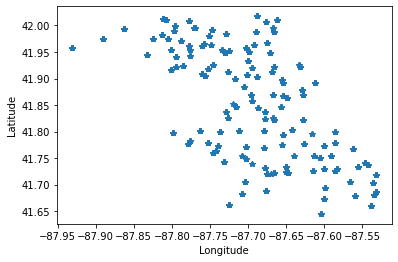

In [20]:
plt.plot(dftrain.Longitude,dftrain.Latitude,'*')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [21]:
#Distinct labels and their counts in Wnvpresent column
display(dftrain.WnvPresent.value_counts())
display(dftrain.WnvPresent.value_counts()/len(dftrain.WnvPresent))

0    9955
1     551
Name: WnvPresent, dtype: int64

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

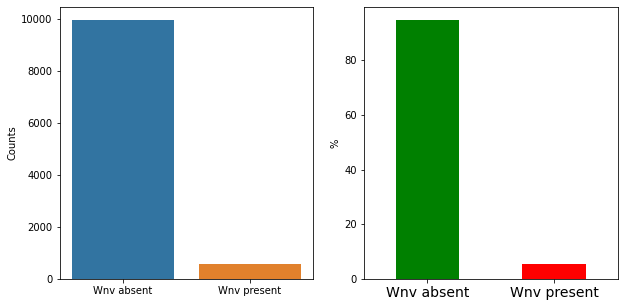

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
x = dftrain.WnvPresent.replace(to_replace=[0, 1], value=['Wnv absent','Wnv present'])
#g1=sns.countplot(x=dftrain.WnvPresent.replace(to_replace=[0, 1], value=['Wnv absent','Wnv present']),ax=ax[0])
g1=sns.countplot(x=x,ax=ax[0])
g1.set(ylabel='Counts')
g1.set(xlabel=None)


y=x.value_counts()*100/len(dftrain.WnvPresent)
#g2=y.replace(to_replace=[0, 1], value=['Wnv absent','Wnv present']).plot(kind='bar', color=('g', 'r'),figsize=(5, 5))
g2=y.replace(to_replace=[0, 1], value=['Wnv absent','Wnv present']).plot(kind='bar', color=('g', 'r'))
plt.ylabel('%')
g2.set_xticklabels(g2.get_xticklabels(), rotation=0,size=14)
plt.show()


In [23]:
#Computing percentage of wnv present in the moquitos counted at the given address 
Address_count=dftrain.Address.value_counts()
Address_wnv=dftrain.groupby('Address')['WnvPresent'].sum().sort_values(ascending=False)
Address_count=Address_count.to_frame().join(Address_wnv.to_frame())
Address_count = Address_count.rename(columns={'Address': 'Sample', 'WnvPresent': 'Wnv_sample'})
Address_count['Wnv_percent']=Address_count.Wnv_sample*100/Address_count.Sample
Address_count.sort_values(by='Sample',ascending=False).head()

,Sample,Wnv_sample,Wnv_percent
"ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA",750,66,8.800000
"South Doty Avenue, Chicago, IL, USA",542,41,7.564576
"South Stony Island Avenue, Chicago, IL, USA",314,16,5.095541
"4100 North Oak Park Avenue, Chicago, IL 60634, USA",185,18,9.729730
"4200 West 127th Street, Alsip, IL 60803, USA",183,8,4.371585


In [24]:
Address_count.sort_values(by='Wnv_percent',ascending=False).head()

,Sample,Wnv_sample,Wnv_percent
"6500 North Oak Park Avenue, Chicago, IL 60631, USA",31,6,19.354839
"6000 North Avondale Avenue, Chicago, IL 60631, USA",24,4,16.666667
"6000 West Roscoe Street, Chicago, IL 60634, USA",14,2,14.285714
"7100 North Harlem Avenue, Chicago, IL 60631, USA",50,7,14.000000
"6400 West Strong Street, Chicago, IL, USA",30,4,13.333333


ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA  is the location where the maximum number of samples were collected and 8.8% of them contains the West Nile Virus. The highest percentage of virus was seen in the samples collected from 6500 North Oak Park Avenue, Chicago, IL 60631, USA

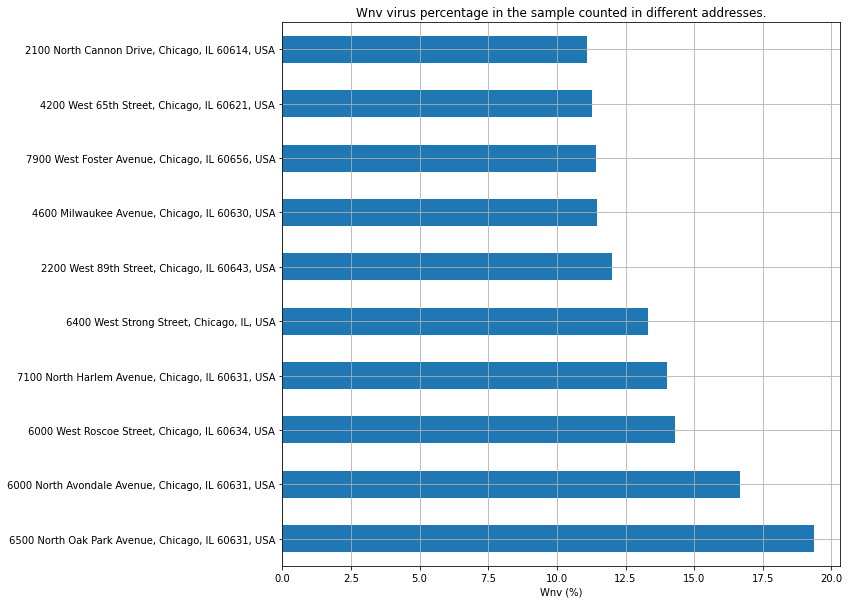

In [25]:
Address_count.Wnv_percent.sort_values(ascending=False).head(10).plot(kind='barh', figsize=(10, 10), title='Wnv virus percentage in the sample counted in different addresses.')
plt.xlabel('Wnv (%)')
plt.grid()
plt.show()

In [26]:
#Distinct Species
len(dftrain.Species.unique())

7

In [27]:
dftrain.Species.value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [28]:
Species_count=dftrain.Species.value_counts()
Species_wnv=dftrain.groupby('Species')['WnvPresent'].sum().sort_values(ascending=False)
Species_count=Species_count.to_frame().join(Species_wnv.to_frame())
Species_count = Species_count.rename(columns={'Species': 'Sample', 'WnvPresent': 'Wnv_sample'})
Species_count['Wnv_percent']=Species_count.Wnv_sample*100/Species_count.Sample
Species_count.reset_index(inplace=True)
Species_count=Species_count.rename(columns={'index': 'Species'})
#Species_count.set_index(["Species"], inplace = True)
Species_count.sort_values(by='Wnv_percent',ascending=False)

,Species,Sample,Wnv_sample,Wnv_percent
2,CULEX PIPIENS,2699,240,8.892182
0,CULEX PIPIENS/RESTUANS,4752,262,5.513468
1,CULEX RESTUANS,2740,49,1.788321
3,CULEX TERRITANS,222,0,0.000000
4,CULEX SALINARIUS,86,0,0.000000
5,CULEX TARSALIS,6,0,0.000000
6,CULEX ERRATICUS,1,0,0.000000


There exists six species of mosquitos. Four species of mosquitoes do not contain the West Nile Virus. As the other two species containing virus were referred to as species together, there must have been a trap of both types of mosquitos in the same sample.

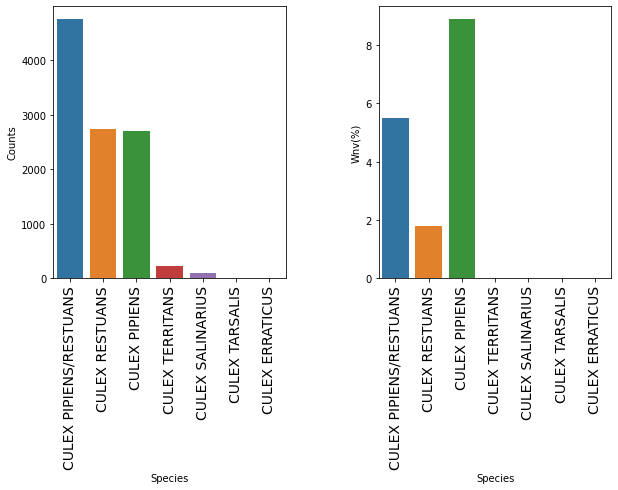

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
g1=sns.barplot(x="Species", y="Sample", data=Species_count,ax=ax[0])
g1.set_xticklabels(g1.get_xticklabels(), rotation=90,size=14)
g1.set(ylabel='Counts')
#g1.set(xlabel=None)
g2=sns.barplot(x="Species", y="Wnv_percent", data=Species_count,ax=ax[1])
g2.set_xticklabels (g2.get_xticklabels(), rotation=90,size=14)
g2.set(ylabel='Wnv(%)')
plt.subplots_adjust(wspace=0.4)

plt.show()

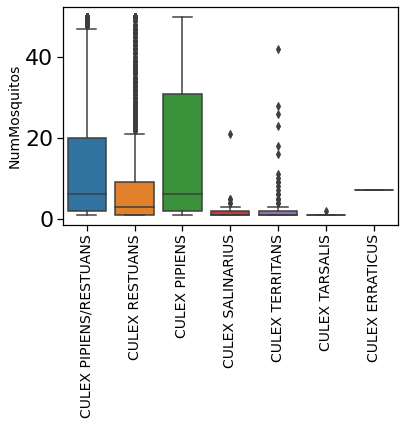

In [30]:
plt.figsize=(5, 5)
sns.set_context("notebook", font_scale=2)
g=sns.boxplot(x="Species", y="NumMosquitos", data=dftrain)
g.set_xticklabels(g.get_xticklabels(), rotation=90,size=14)
g.set(xlabel=None)
g.xaxis.label.set_size(14)
g.yaxis.label.set_size(14)
plt.show()

In [31]:
Species_mosquito_no=dftrain.groupby('Species')['NumMosquitos'].sum().sort_values(ascending=False)
Species_mosquito_no

Species
CULEX PIPIENS/RESTUANS    66268
CULEX PIPIENS             44671
CULEX RESTUANS            23431
CULEX TERRITANS             510
CULEX SALINARIUS            145
CULEX TARSALIS                7
CULEX ERRATICUS               7
Name: NumMosquitos, dtype: int64

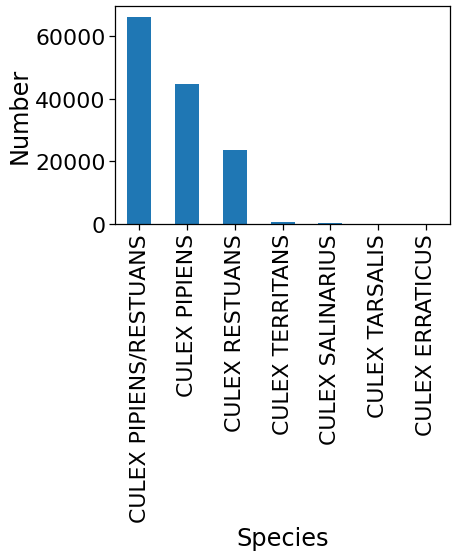

In [32]:
plt.figsize=(5, 5)
Species_mosquito_no.plot(kind='bar')
plt.ylabel('Number')
plt.xlabel('Species')
plt.show()



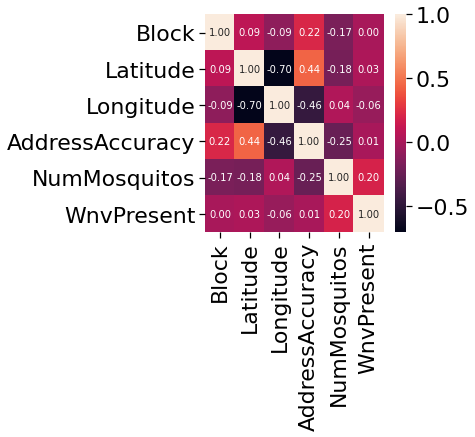

In [33]:
#Visualize correlation of target variable WnvPresent with other feathures
plt.subplots(figsize=(4,4))

corr = dftrain.corr(method='pearson')
#sns.heatmap(dfweather_station[weather_features].corr());
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")

## 2. Analyzing Weather data<a id='2._Analyzing training data'></a>

In [34]:
#Reading weather data
dfweather = pd.read_csv("weather.csv")

In [35]:
#Visualizing first five lines of weather data
dfweather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [36]:
#Number of columns and rows in weather data
dfweather.shape

(2944, 22)

In [37]:
#Columns name in weather data
dfweather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [38]:
#Column's data type and their non-null count
dfweather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [39]:
#Checking missing values
dfweather.isin(['?']).sum(axis=0)

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [40]:
#Checking missing values
dfweather.isin(['-']).sum(axis=0)

Station           0
Date              0
Tmax              0
Tmin              0
Tavg              0
Depart            0
DewPoint          0
WetBulb           0
Heat              0
Cool              0
Sunrise        1472
Sunset         1472
CodeSum           0
Depth             0
Water1            0
SnowFall          0
PrecipTotal       0
StnPressure       0
SeaLevel          0
ResultSpeed       0
ResultDir         0
AvgSpeed          0
dtype: int64

In [41]:
dfweather.isin(['M']).sum(axis=0)

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise           0
Sunset            0
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

In [42]:
dfweather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [43]:
#Drop Water1 columns having entire missing values
dfweather=dfweather.drop(columns=['Water1'], axis = 1)

In [44]:
dfweather.isin(['  T']).sum(axis=0)

Station          0
Date             0
Tmax             0
Tmin             0
Tavg             0
Depart           0
DewPoint         0
WetBulb          0
Heat             0
Cool             0
Sunrise          0
Sunset           0
CodeSum          0
Depth            0
SnowFall        12
PrecipTotal    318
StnPressure      0
SeaLevel         0
ResultSpeed      0
ResultDir        0
AvgSpeed         0
dtype: int64

In [45]:
dfweather.SnowFall.value_counts()

M      1472
0.0    1459
  T      12
0.1       1
Name: SnowFall, dtype: int64

In [46]:
#Drop SnowFall columns as there exist only one row having snowfall data
dfweather=dfweather.drop(columns=['SnowFall'], axis = 1)

In [47]:
dfweather.PrecipTotal.value_counts()

0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
1.88       1
3.66       1
1.30       1
2.20       1
2.03       1
Name: PrecipTotal, Length: 168, dtype: int64

In [48]:
#Replace the trace value with the average between 0 and 0.01
dfweather["PrecipTotal"]=[0.005 if i=='  T' else i for i in dfweather.PrecipTotal]

In [49]:
#Replacing Missing, Trace and - values with nan
dfweather.replace('M', np.nan,inplace=True)
dfweather.replace('-', np.nan,inplace=True)

In [50]:
#Converting Date to datetime
dfweather['Date']=pd.to_datetime(dfweather['Date'])
#Checking unique dates having mosquitos count
print(dfweather['Date'].dt.year.unique())
print(dfweather['Date'].dt.month.unique())
print(len(dfweather.Date.unique()))

[2007 2008 2009 2010 2011 2012 2013 2014]
[ 5  6  7  8  9 10]
1472


In [51]:
#Checking the number of weather stations
dfweather.Station.unique()

array([1, 2])

There exist two weather stations reporting weather parameters. Separate the weather data from station 1 and station 2.

## 2.1 Separating and merging weather parameters from two stations <a id='2.1_Separating and merging weather parameters from two stations'></a>

In [52]:
#Separation station1 and station2 data
dfweather_station1 =dfweather[dfweather['Station'] == 1]
dfweather_station2 =dfweather[dfweather['Station'] == 2]

In [53]:
dfweather_station1=dfweather_station1.drop(columns=['Station'], axis = 1)
dfweather_station2=dfweather_station2.drop(columns=['Station'], axis = 1)

In [54]:
#Merging station1 and station2 data
dfweather_station=dfweather_station1.merge(dfweather_station2,on='Date')

In [55]:
dfweather_station.head()

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,...,Sunrise_y,Sunset_y,CodeSum_y,Depth_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2007-05-01,83,50,67,14,51,56,0,2,0448,...,NaN,NaN,,NaN,0.00,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47,14,0,0447,...,NaN,NaN,BR HZ,NaN,0.00,29.44,30.08,13.3,2,13.4
2,2007-05-03,66,46,56,2,40,48,9,0,0446,...,NaN,NaN,HZ,NaN,0.00,29.46,30.12,12.9,6,13.2
3,2007-05-04,66,49,58,4,41,50,7,0,0444,...,NaN,NaN,,NaN,0.00,29.36,30.04,10.1,7,10.4
4,2007-05-05,66,53,60,5,38,49,5,0,0443,...,NaN,NaN,,NaN,0.005,29.46,30.09,11.2,7,11.5


In [56]:
dfweather_station.tail()

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,...,Sunrise_y,Sunset_y,CodeSum_y,Depth_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
1467,2014-10-27,77,51,64,16,51,58,1,0,0618,...,NaN,NaN,RA,NaN,0.02,29.00,29.67,12.7,19,13.6
1468,2014-10-28,68,45,57,10,38,47,8,0,0619,...,NaN,NaN,RA,NaN,0.03,29.23,29.85,14.0,26,14.6
1469,2014-10-29,49,36,43,-4,32,40,22,0,0620,...,NaN,NaN,,NaN,0.00,29.42,30.07,8.5,29,9.0
1470,2014-10-30,51,32,42,-4,34,40,23,0,0622,...,NaN,NaN,RA,NaN,0.005,29.41,30.10,5.9,23,6.5
1471,2014-10-31,47,33,40,-6,25,33,25,0,0623,...,NaN,NaN,RA SN BR,NaN,0.04,29.54,30.20,21.7,34,22.6


In [57]:
dfweather_station.columns

Index(['Date', 'Tmax_x', 'Tmin_x', 'Tavg_x', 'Depart_x', 'DewPoint_x',
       'WetBulb_x', 'Heat_x', 'Cool_x', 'Sunrise_x', 'Sunset_x', 'CodeSum_x',
       'Depth_x', 'PrecipTotal_x', 'StnPressure_x', 'SeaLevel_x',
       'ResultSpeed_x', 'ResultDir_x', 'AvgSpeed_x', 'Tmax_y', 'Tmin_y',
       'Tavg_y', 'Depart_y', 'DewPoint_y', 'WetBulb_y', 'Heat_y', 'Cool_y',
       'Sunrise_y', 'Sunset_y', 'CodeSum_y', 'Depth_y', 'PrecipTotal_y',
       'StnPressure_y', 'SeaLevel_y', 'ResultSpeed_y', 'ResultDir_y',
       'AvgSpeed_y'],
      dtype='object')

In [58]:
#Merged weather data column information
dfweather_station.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1472 non-null   datetime64[ns]
 1   Tmax_x         1472 non-null   int64         
 2   Tmin_x         1472 non-null   int64         
 3   Tavg_x         1472 non-null   object        
 4   Depart_x       1472 non-null   object        
 5   DewPoint_x     1472 non-null   int64         
 6   WetBulb_x      1469 non-null   object        
 7   Heat_x         1472 non-null   object        
 8   Cool_x         1472 non-null   object        
 9   Sunrise_x      1472 non-null   object        
 10  Sunset_x       1472 non-null   object        
 11  CodeSum_x      1472 non-null   object        
 12  Depth_x        1472 non-null   object        
 13  PrecipTotal_x  1472 non-null   object        
 14  StnPressure_x  1470 non-null   object        
 15  SeaLevel_x     1467 n

In [59]:
dfweather_station.isnull().sum()

Date                0
Tmax_x              0
Tmin_x              0
Tavg_x              0
Depart_x            0
DewPoint_x          0
WetBulb_x           3
Heat_x              0
Cool_x              0
Sunrise_x           0
Sunset_x            0
CodeSum_x           0
Depth_x             0
PrecipTotal_x       0
StnPressure_x       2
SeaLevel_x          5
ResultSpeed_x       0
ResultDir_x         0
AvgSpeed_x          0
Tmax_y              0
Tmin_y              0
Tavg_y             11
Depart_y         1472
DewPoint_y          0
WetBulb_y           1
Heat_y             11
Cool_y             11
Sunrise_y        1472
Sunset_y         1472
CodeSum_y           0
Depth_y          1472
PrecipTotal_y       2
StnPressure_y       2
SeaLevel_y          4
ResultSpeed_y       0
ResultDir_y         0
AvgSpeed_y          3
dtype: int64

In [60]:
#Removing columns having entire null values
dfweather_station=dfweather_station.drop(columns=['CodeSum_x','Depart_y','Sunrise_y',
             'Sunset_y','CodeSum_y','Depth_y'], axis = 1)

In [61]:
dfweather_station.head()

,Date,Tmax_x,Tmin_x,Tavg_x,Depart_x,DewPoint_x,WetBulb_x,Heat_x,Cool_x,Sunrise_x,...,DewPoint_y,WetBulb_y,Heat_y,Cool_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,2007-05-01,83,50,67,14,51,56,0,2,0448,...,51,57,0,3,0.00,29.18,29.82,2.7,25,9.6
1,2007-05-02,59,42,51,-3,42,47,14,0,0447,...,42,47,13,0,0.00,29.44,30.08,13.3,2,13.4
2,2007-05-03,66,46,56,2,40,48,9,0,0446,...,40,50,7,0,0.00,29.46,30.12,12.9,6,13.2
3,2007-05-04,66,49,58,4,41,50,7,0,0444,...,42,50,NaN,NaN,0.00,29.36,30.04,10.1,7,10.4
4,2007-05-05,66,53,60,5,38,49,5,0,0443,...,39,50,5,0,0.005,29.46,30.09,11.2,7,11.5


In [62]:
dfweather_station.isnull().sum()

Date              0
Tmax_x            0
Tmin_x            0
Tavg_x            0
Depart_x          0
DewPoint_x        0
WetBulb_x         3
Heat_x            0
Cool_x            0
Sunrise_x         0
Sunset_x          0
Depth_x           0
PrecipTotal_x     0
StnPressure_x     2
SeaLevel_x        5
ResultSpeed_x     0
ResultDir_x       0
AvgSpeed_x        0
Tmax_y            0
Tmin_y            0
Tavg_y           11
DewPoint_y        0
WetBulb_y         1
Heat_y           11
Cool_y           11
PrecipTotal_y     2
StnPressure_y     2
SeaLevel_y        4
ResultSpeed_y     0
ResultDir_y       0
AvgSpeed_y        3
dtype: int64

In [63]:
#Checking object columns
dfweather_station.select_dtypes('object').columns


Index(['Tavg_x', 'Depart_x', 'WetBulb_x', 'Heat_x', 'Cool_x', 'Sunrise_x',
       'Sunset_x', 'Depth_x', 'PrecipTotal_x', 'StnPressure_x', 'SeaLevel_x',
       'AvgSpeed_x', 'Tavg_y', 'WetBulb_y', 'Heat_y', 'Cool_y',
       'PrecipTotal_y', 'StnPressure_y', 'SeaLevel_y', 'AvgSpeed_y'],
      dtype='object')

In [64]:
# Convert sunset into datetime format after inserting ':' in between hour and minute
dfweather_station['Sunrise'] = dfweather_station['Sunrise_x'].map(lambda x: x[0:2]+':'+x[2:4])
dfweather_station['Sunrise']=pd.to_datetime(dfweather_station.Sunrise,format='%H:%M')-pd.to_datetime('1900-01-01 00:00:00')
dfweather_station.Sunrise

0      0 days 04:48:00
1      0 days 04:47:00
2      0 days 04:46:00
3      0 days 04:44:00
4      0 days 04:43:00
             ...      
1467   0 days 06:18:00
1468   0 days 06:19:00
1469   0 days 06:20:00
1470   0 days 06:22:00
1471   0 days 06:23:00
Name: Sunrise, Length: 1472, dtype: timedelta64[ns]

In [65]:
dfweather_station['Sunset'] = dfweather_station['Sunset_x'].map(lambda x: x[0:2]+':'+x[2:4])
dfweather_station.Sunset_x.unique()

array(['1849', '1850', '1851', '1852', '1853', '1855', '1856', '1857',
       '1858', '1859', '1860', '1901', '1902', '1903', '1904', '1905',
       '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913',
       '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921',
       '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929',
       '1930', '1931', '1900', '1854', '1848', '1846', '1845', '1843',
       '1842', '1840', '1839', '1837', '1835', '1834', '1832', '1831',
       '1829', '1827', '1826', '1824', '1822', '1821', '1819', '1817',
       '1815', '1814', '1812', '1810', '1809', '1807', '1805', '1803',
       '1760', '1758', '1756', '1755', '1753', '1751', '1749', '1748',
       '1746', '1744', '1742', '1741', '1739', '1737', '1735', '1734',
       '1732', '1730', '1729', '1727', '1725', '1724', '1722', '1720',
       '1719', '1717', '1715', '1714', '1712', '1711', '1709', '1707',
       '1706', '1704', '1703', '1701', '1660', '1658', '1657', '1656',
      

In [66]:
dfweather_station.Sunset_x.replace('1860','1900',inplace=True)
dfweather_station.Sunset_x.replace('1760','1800',inplace=True)
dfweather_station.Sunset_x.replace('1660','1700',inplace=True)

In [67]:
# Convert sunset into datetime format after inserting ':' in between hour and minute
dfweather_station['Sunset'] = dfweather_station['Sunset_x'].apply(lambda x: x[0:2]+':'+x[2:4])
dfweather_station['Sunset']=pd.to_datetime(dfweather_station.Sunset,format='%H:%M')-pd.to_datetime('1900-01-01 00:00:00')
dfweather_station.Sunset





0      0 days 18:49:00
1      0 days 18:50:00
2      0 days 18:51:00
3      0 days 18:52:00
4      0 days 18:53:00
             ...      
1467   0 days 16:53:00
1468   0 days 16:51:00
1469   0 days 16:50:00
1470   0 days 16:49:00
1471   0 days 16:47:00
Name: Sunset, Length: 1472, dtype: timedelta64[ns]

In [68]:
# Calculat day time as sunset - sunrise
dfweather_station['Daytime_length']=(dfweather_station['Sunset']-dfweather_station['Sunrise']).astype(str)
dfweather_station['Daytime_length']=round(dfweather_station.Daytime_length.str.slice(7, 12, 1).str.split(':').apply(lambda x: (float(x[0])  + float(x[1])/60.0  )),2)

In [69]:
#Converting object columns to integer type
dfweather_station[['Tavg_x', 'Depart_x', 'WetBulb_x', 'Heat_x', 'Cool_x',
                   'WetBulb_y', 'Heat_y', 'Cool_y','Tavg_y'] ]=dfweather_station[['Tavg_x', 'Depart_x',
                   'WetBulb_x', 'Heat_x', 'Cool_x','WetBulb_y', 
                   'Heat_y', 'Cool_y','Tavg_y' ]].apply(pd.to_numeric)

In [70]:
#Converting object columns to float type
dfweather_station[['Depth_x', 'PrecipTotal_x','StnPressure_x', 'SeaLevel_x', 'AvgSpeed_x',
                   'PrecipTotal_y', 'StnPressure_y','SeaLevel_y', 'AvgSpeed_y'] ]=dfweather_station[['Depth_x',
                    'PrecipTotal_x','StnPressure_x', 'SeaLevel_x', 'AvgSpeed_x','PrecipTotal_y',
                    'StnPressure_y','SeaLevel_y', 'AvgSpeed_y' ]].apply(pd.to_numeric, downcast='float')

In [71]:
dfweather_station.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   Date            1472 non-null   datetime64[ns] 
 1   Tmax_x          1472 non-null   int64          
 2   Tmin_x          1472 non-null   int64          
 3   Tavg_x          1472 non-null   int64          
 4   Depart_x        1472 non-null   int64          
 5   DewPoint_x      1472 non-null   int64          
 6   WetBulb_x       1469 non-null   float64        
 7   Heat_x          1472 non-null   int64          
 8   Cool_x          1472 non-null   int64          
 9   Sunrise_x       1472 non-null   object         
 10  Sunset_x        1472 non-null   object         
 11  Depth_x         1472 non-null   float32        
 12  PrecipTotal_x   1472 non-null   float32        
 13  StnPressure_x   1470 non-null   float32        
 14  SeaLevel_x      1467 non-null   float32 

In [72]:
dfweather_station['Tmax']=dfweather_station[['Tmax_x', 'Tmax_y']].mean(axis=1)
dfweather_station['Tmin']=dfweather_station[['Tmin_x', 'Tmin_y']].mean(axis=1)
dfweather_station['Tavg']=dfweather_station[['Tavg_x', 'Tavg_y']].mean(axis=1)
dfweather_station['DewPoint']=dfweather_station[['DewPoint_x', 'DewPoint_y']].mean(axis=1)
dfweather_station['WetBulb']=dfweather_station[['WetBulb_x', 'WetBulb_y']].mean(axis=1)
dfweather_station['Heat']=dfweather_station[['Heat_x', 'Heat_y']].mean(axis=1)
dfweather_station['Cool']=dfweather_station[['Cool_x', 'Cool_y']].mean(axis=1)
dfweather_station['PrecipTotal']=dfweather_station[['PrecipTotal_x', 'PrecipTotal_y']].mean(axis=1)
dfweather_station['StnPressure']=dfweather_station[['StnPressure_x', 'StnPressure_y']].mean(axis=1)
dfweather_station['SeaLevel']=dfweather_station[['SeaLevel_x', 'SeaLevel_y']].mean(axis=1)
dfweather_station['ResultSpeed']=dfweather_station[['ResultSpeed_x', 'ResultSpeed_y']].mean(axis=1)
dfweather_station['ResultDir']=dfweather_station[['ResultDir_x', 'ResultDir_y']].mean(axis=1)
dfweather_station['AvgSpeed']=dfweather_station[['AvgSpeed_x', 'AvgSpeed_y']].mean(axis=1)


In [73]:
dfweather_station.rename(columns = {'Depart_x':'Depart', 'Depth_x':'Depth'},  inplace = True)



In [74]:
dfweather_station.isnull().sum()



Date               0
Tmax_x             0
Tmin_x             0
Tavg_x             0
Depart             0
DewPoint_x         0
WetBulb_x          3
Heat_x             0
Cool_x             0
Sunrise_x          0
Sunset_x           0
Depth              0
PrecipTotal_x      0
StnPressure_x      2
SeaLevel_x         5
ResultSpeed_x      0
ResultDir_x        0
AvgSpeed_x         0
Tmax_y             0
Tmin_y             0
Tavg_y            11
DewPoint_y         0
WetBulb_y          1
Heat_y            11
Cool_y            11
PrecipTotal_y      2
StnPressure_y      2
SeaLevel_y         4
ResultSpeed_y      0
ResultDir_y        0
AvgSpeed_y         3
Sunrise            0
Sunset             0
Daytime_length     0
Tmax               0
Tmin               0
Tavg               0
DewPoint           0
WetBulb            0
Heat               0
Cool               0
PrecipTotal        0
StnPressure        1
SeaLevel           0
ResultSpeed        0
ResultDir          0
AvgSpeed           0
dtype: int64

In [75]:
def relative_humidity(Tavg,DewPoint):
    
    Tavg_celsius = (Tavg-32.0)/1.8
    DewPoint_celsius = (DewPoint-32.0)/1.8
    
    saturation_vapour_pressure = 6.11*10.0**(7.5*Tavg_celsius/(237.7+Tavg_celsius))
    actual_pressure = 6.11*10.0**(7.5*DewPoint_celsius/(237.7+DewPoint_celsius))
    
    return round(((actual_pressure/saturation_vapour_pressure)*100),2)

dfweather_station['Relative_humidity']=relative_humidity(dfweather_station.Tavg,dfweather_station.DewPoint)

In [76]:
dfweather_station=dfweather_station.drop(columns=['Tmax_x', 'Tmax_y','Tmin_x','Sunrise_x','Sunset_x', 'Tmin_y','Tavg_x', 'Tavg_y','DewPoint_x', 
                                                  'DewPoint_y','WetBulb_x', 'WetBulb_y','Heat_x', 'Heat_y','Cool_x', 
                                                  'Cool_y','PrecipTotal_x', 'PrecipTotal_y' ,'StnPressure_x', 'StnPressure_y',
                                                  'SeaLevel_x', 'SeaLevel_y','ResultSpeed_x', 'ResultSpeed_y','ResultDir_x',
                                                  'ResultDir_y','AvgSpeed_x', 'AvgSpeed_y'], axis = 1)

In [77]:
dfweather_station['DewPoint_depression']=dfweather_station.Tavg-dfweather_station.DewPoint
dfweather_station['WetBulb_depression']=dfweather_station.Tavg-dfweather_station.WetBulb



In [78]:
dfweather_station.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Date                 1472 non-null   datetime64[ns] 
 1   Depart               1472 non-null   int64          
 2   Depth                1472 non-null   float32        
 3   Sunrise              1472 non-null   timedelta64[ns]
 4   Sunset               1472 non-null   timedelta64[ns]
 5   Daytime_length       1472 non-null   float64        
 6   Tmax                 1472 non-null   float64        
 7   Tmin                 1472 non-null   float64        
 8   Tavg                 1472 non-null   float64        
 9   DewPoint             1472 non-null   float64        
 10  WetBulb              1472 non-null   float64        
 11  Heat                 1472 non-null   float64        
 12  Cool                 1472 non-null   float64        
 13  PrecipTotal       

In [79]:
#Unique values and their counts in Depth
print(dfweather_station.Depth.unique())
print(dfweather_station.Depth.value_counts())
dfweather_station=dfweather_station.drop(columns=['Depth'], axis = 1)


[0.]
0.0    1472
Name: Depth, dtype: int64


In [80]:
dfweather_station.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Date                 1472 non-null   datetime64[ns] 
 1   Depart               1472 non-null   int64          
 2   Sunrise              1472 non-null   timedelta64[ns]
 3   Sunset               1472 non-null   timedelta64[ns]
 4   Daytime_length       1472 non-null   float64        
 5   Tmax                 1472 non-null   float64        
 6   Tmin                 1472 non-null   float64        
 7   Tavg                 1472 non-null   float64        
 8   DewPoint             1472 non-null   float64        
 9   WetBulb              1472 non-null   float64        
 10  Heat                 1472 non-null   float64        
 11  Cool                 1472 non-null   float64        
 12  PrecipTotal          1472 non-null   float32        
 13  StnPressure       

In [81]:
dfweather_station.head()


,Date,Depart,Sunrise,Sunset,Daytime_length,Tmax,Tmin,Tavg,DewPoint,WetBulb,...,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Relative_humidity,DewPoint_depression,WetBulb_depression
0,2007-05-01,14,0 days 04:48:00,0 days 18:49:00,14.02,83.5,51.0,67.5,51.0,56.5,...,2.5,0.0000,29.139999,29.820000,2.20,26.0,9.400000,55.50,16.5,11.0
1,2007-05-02,-3,0 days 04:47:00,0 days 18:50:00,14.05,59.5,42.5,51.5,42.0,47.0,...,0.0,0.0000,29.410000,30.084999,13.15,3.0,13.400000,69.88,9.5,4.5
2,2007-05-03,2,0 days 04:46:00,0 days 18:51:00,14.08,66.5,47.0,57.0,40.0,49.0,...,0.0,0.0000,29.424999,30.120001,12.30,6.5,12.549999,52.92,17.0,8.0
3,2007-05-04,4,0 days 04:44:00,0 days 18:52:00,14.13,72.0,50.0,58.0,41.5,50.0,...,0.0,0.0025,29.334999,30.045000,10.25,7.5,10.600000,54.11,16.5,8.0
4,2007-05-05,5,0 days 04:43:00,0 days 18:53:00,14.17,66.0,53.5,60.0,38.5,49.5,...,0.0,0.0050,29.430000,30.095001,11.45,7.0,11.750000,44.83,21.5,10.5


In [82]:
dfweather_station.isnull().sum()


Date                   0
Depart                 0
Sunrise                0
Sunset                 0
Daytime_length         0
Tmax                   0
Tmin                   0
Tavg                   0
DewPoint               0
WetBulb                0
Heat                   0
Cool                   0
PrecipTotal            0
StnPressure            1
SeaLevel               0
ResultSpeed            0
ResultDir              0
AvgSpeed               0
Relative_humidity      0
DewPoint_depression    0
WetBulb_depression     0
dtype: int64

In [83]:
#dfweather_station.select_dtypes('object').columns
dfweather_station.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype          
---  ------               --------------  -----          
 0   Date                 1472 non-null   datetime64[ns] 
 1   Depart               1472 non-null   int64          
 2   Sunrise              1472 non-null   timedelta64[ns]
 3   Sunset               1472 non-null   timedelta64[ns]
 4   Daytime_length       1472 non-null   float64        
 5   Tmax                 1472 non-null   float64        
 6   Tmin                 1472 non-null   float64        
 7   Tavg                 1472 non-null   float64        
 8   DewPoint             1472 non-null   float64        
 9   WetBulb              1472 non-null   float64        
 10  Heat                 1472 non-null   float64        
 11  Cool                 1472 non-null   float64        
 12  PrecipTotal          1472 non-null   float32        
 13  StnPressure       

In [84]:
weather_features = [x for x in dfweather_station.columns if x not in ['Date','Sunrise','Sunset','Daytime']]
weather_features


['Depart',
 'Daytime_length',
 'Tmax',
 'Tmin',
 'Tavg',
 'DewPoint',
 'WetBulb',
 'Heat',
 'Cool',
 'PrecipTotal',
 'StnPressure',
 'SeaLevel',
 'ResultSpeed',
 'ResultDir',
 'AvgSpeed',
 'Relative_humidity',
 'DewPoint_depression',
 'WetBulb_depression']

In [85]:
weather_parameters=dfweather_station[weather_features]
weather_parameters.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Depart               1472 non-null   int64  
 1   Daytime_length       1472 non-null   float64
 2   Tmax                 1472 non-null   float64
 3   Tmin                 1472 non-null   float64
 4   Tavg                 1472 non-null   float64
 5   DewPoint             1472 non-null   float64
 6   WetBulb              1472 non-null   float64
 7   Heat                 1472 non-null   float64
 8   Cool                 1472 non-null   float64
 9   PrecipTotal          1472 non-null   float32
 10  StnPressure          1471 non-null   float32
 11  SeaLevel             1472 non-null   float32
 12  ResultSpeed          1472 non-null   float64
 13  ResultDir            1472 non-null   float64
 14  AvgSpeed             1472 non-null   float32
 15  Relative_humidity    1472 non-null   f

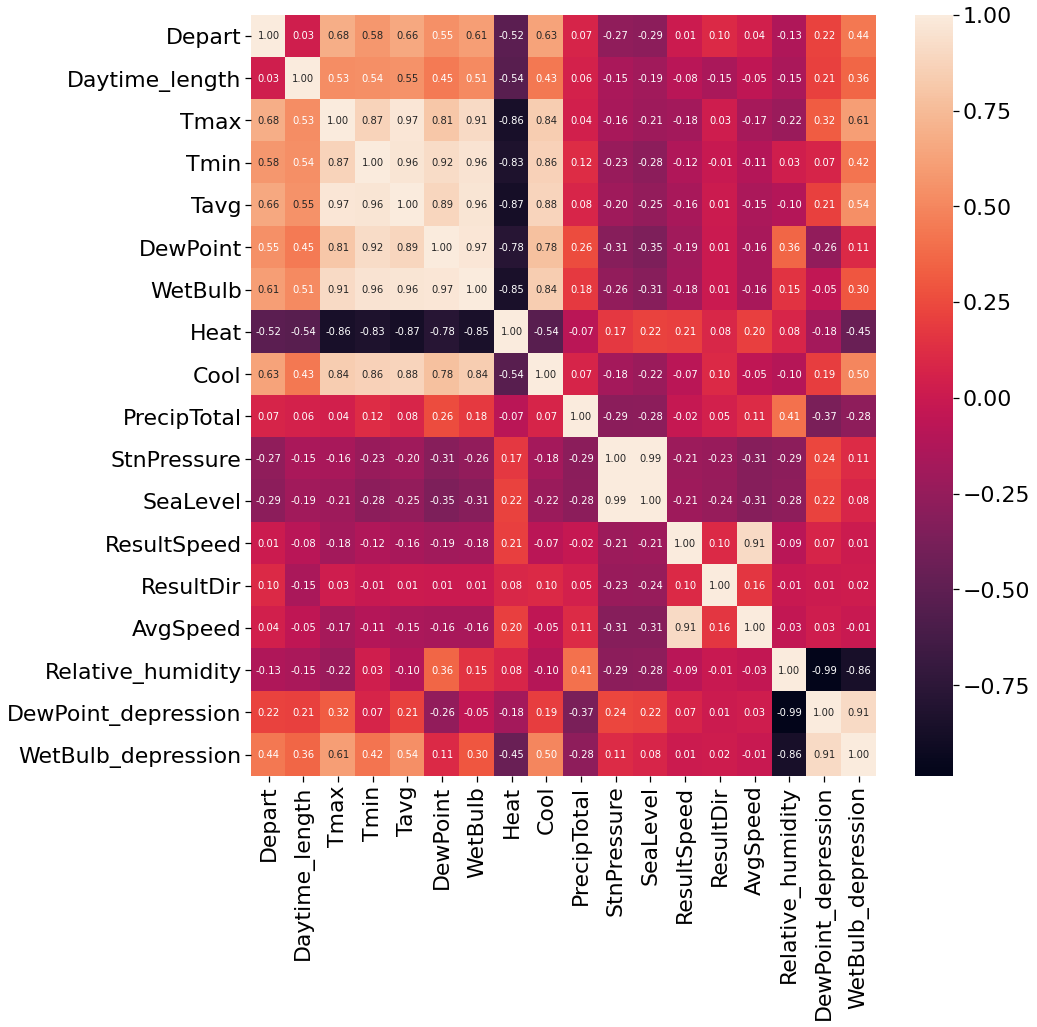

In [86]:
plt.subplots(figsize=(14,14))

corr = dfweather_station.corr(method='pearson')
#sns.heatmap(dfweather_station[weather_features].corr());
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")
plt.savefig('heatmap.png',dpi=600)

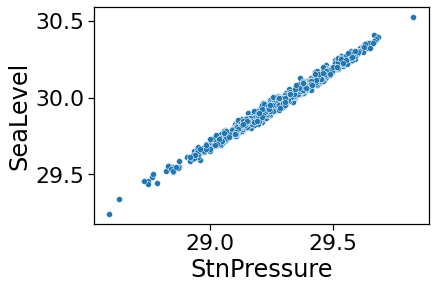

In [87]:
#Highly positive correlation coefficient 0.99  betweenStnPressure and SeaLevel. Similarly,  highly negative correlation coefficient -0.97 between Sunset and Sunrise. 
#fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig, ax = figsize=(10, 5)
sns.scatterplot(x='StnPressure',y='SeaLevel', data=dfweather_station)
#sns.scatterplot(y='Sunset',x='Sunrise', data=dfweather_station,ax=ax[1])
#plt.subplots_adjust(wspace=0.5)
plt.show()


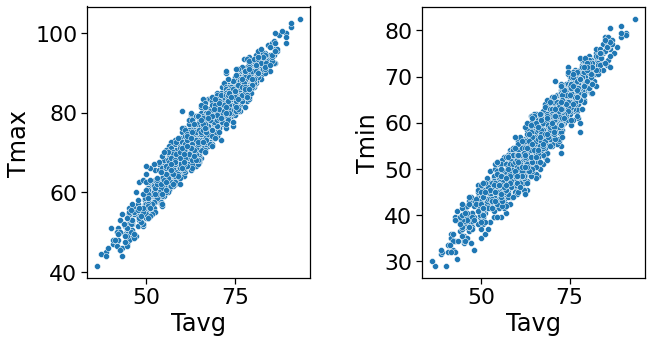

In [88]:
#Correlation coefficient of average temperature and maximum temperature is high 0.96. Similar value for average temperature and minimum temperature
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x='Tavg',y='Tmax', data=dfweather_station,ax=ax[0])
sns.scatterplot(x='Tavg',y='Tmin', data=dfweather_station,ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.show()

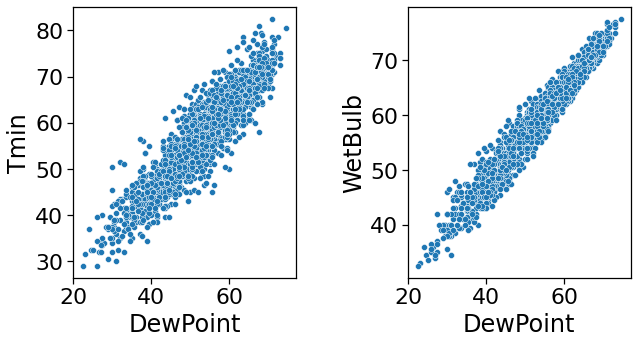

In [89]:
#plots of DewPoint with WetBulb and minimum temperature as they exhibit highly positive correlation coefficients as 0.97 and 0.91 respectively
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x='DewPoint',y='Tmin', data=dfweather_station,ax=ax[0])
sns.scatterplot(x='DewPoint',y='WetBulb', data=dfweather_station,ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.show()

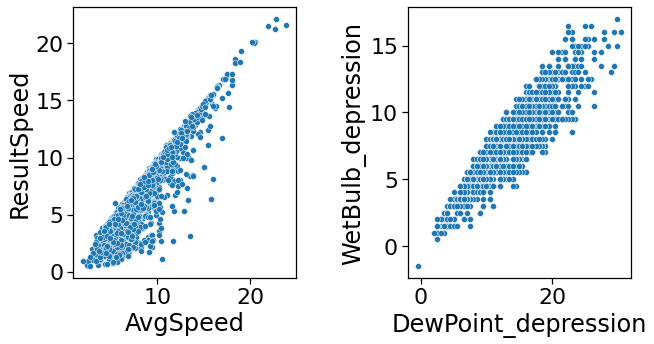

In [90]:
#AvgSpeed and ResultSpeed are highly correlated with 0.91. Same magnitude for DewPoint_depression and WetBulb_depression
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x='AvgSpeed',y='ResultSpeed', data=dfweather_station,ax=ax[0])
sns.scatterplot(x='DewPoint_depression',y='WetBulb_depression', data=dfweather_station,ax=ax[1])
plt.subplots_adjust(wspace=0.5)
plt.show()


In [91]:
#Creating Dayofweek,Day week, month, year from date 
dfweather_station['Day_of_week']=dfweather_station['Date'].dt.dayofweek
dfweather_station['Day_of_month']=dfweather_station['Date'].dt.day
dfweather_station['Week']=dfweather_station['Date'].dt.isocalendar().week
#dfweather_station['Week'] =dfweather_station['Date'].dt.strftime('%U')
##dfweather_station['Week']=dfweather_station['Date'].dt.week
dfweather_station['Month']=dfweather_station['Date'].dt.month
dfweather_station['Year']=dfweather_station['Date'].dt.year


In [92]:
def mkseason(n):
    if 3<=n<=5: season = 'Spring'
    elif 6<=n<=8: season = 'Summer'
    elif 9<=n<=11: season = 'Fall'
    else: season = 'Winter'
    return(season)

In [93]:
dfweather_station['Season'] = dfweather_station.Month.apply(mkseason)


In [94]:

def mkmonth(n):
    if n==5: month = 'May'
    elif n==6: month = 'June'
    elif n==7: month = 'July'
    elif n==8: month = 'Aug'
    elif n==9: month = 'Sep'   
    else: month = 'Oct'
    return(month)

In [95]:
dfweather_station['Monthofyear'] = dfweather_station.Month.apply(mkmonth)

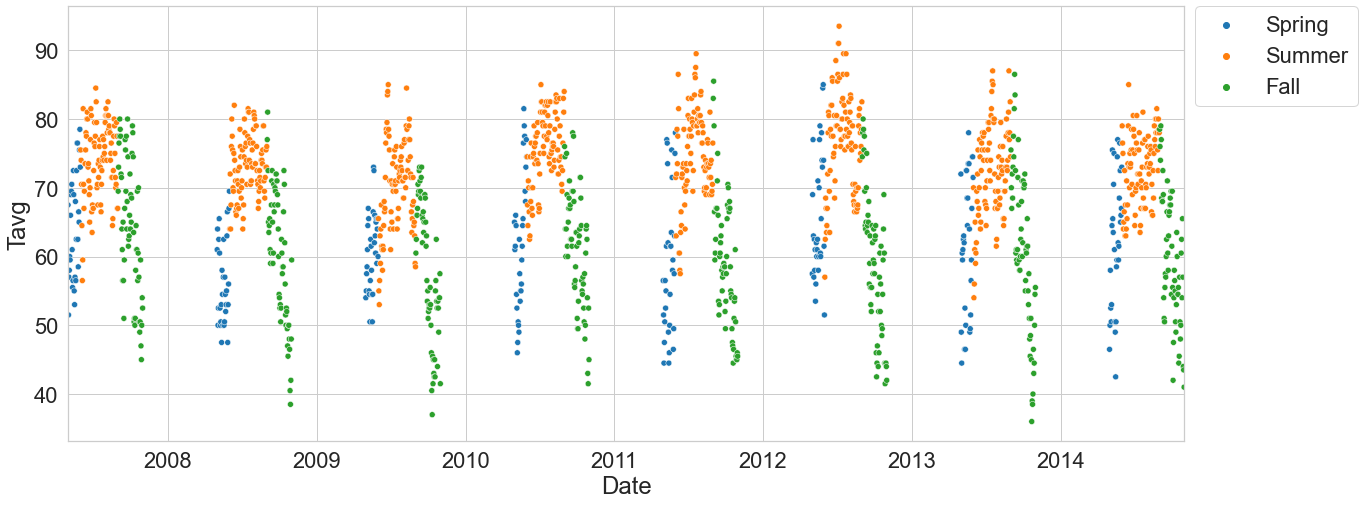

In [96]:
#import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,8))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2)
ax=sns.scatterplot(x="Date", y="Tavg", hue="Season",data=dfweather_station)
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
ax.set_xlim(dfweather_station['Date'].min(), dfweather_station['Date'].max())
#myFmt = mdates.DateFormatter('%H:%M')
#ax.xaxis.set_major_formatter(myFmt)
#for item in ax.get_xticklabels():
#    item.set_rotation(45)
#plt.show()



plt.show()

## 3. Exploratory data analysis on training data merged with weather data <a id='3._Exploratory data analys on training data merged with weather data'></a>

In [97]:
#Merging training data with weather data on date
df=dftrain.merge(dfweather_station, on = 'Date')

In [98]:
df.shape

(10506, 39)

In [99]:
df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,Relative_humidity,DewPoint_depression,WetBulb_depression,Day_of_week,Day_of_month,Week,Month,Year,Season,Monthofyear
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,55.63,17.0,10.0,1,29,22,5,2007,Spring,May


## 3.1 Seasonality of virus <a id='3.1_ Seasonality of virus'></a>

In [100]:
Yearly_count=df.Year.value_counts()
Yearly_wnv=df.groupby('Year')['WnvPresent'].sum().sort_values(ascending=False)
Yearly_count=Yearly_count.to_frame().join(Yearly_wnv.to_frame())
Yearly_count = Yearly_count.rename(columns={'Year': 'Sample', 'WnvPresent': 'Wnv_sample'})
Yearly_count['Wnv_percent']=Yearly_count.Wnv_sample*100/Yearly_count.Sample
Yearly_count.reset_index(inplace=True)
Yearly_count=Yearly_count.rename(columns={'index': 'Year'})
dfgroup_yearly=Yearly_count.copy()
Yearly_count

,Year,Sample,Wnv_sample,Wnv_percent
0,2007,3811,236,6.192600
1,2013,2392,239,9.991639
2,2009,2249,19,0.844820
3,2011,2054,57,2.775073


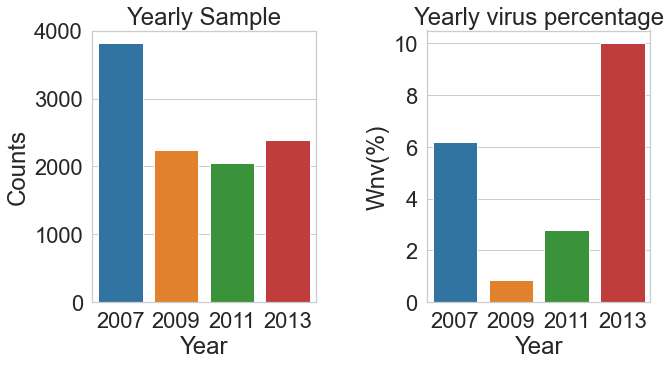

In [101]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.figsize=(2, 2)
#sns.set_theme(style="whitegrid")
g1=sns.barplot(x="Year", y="Sample", data=Yearly_count,ax=ax[0])
g1.set(ylabel='Counts')
g1.set(title="Yearly Sample")
#g1.set(xlabel=None)
g2=sns.barplot(x="Year", y="Wnv_percent", data=Yearly_count,ax=ax[1])
#plt.get_legend()
#plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0).remove()
g2.set(ylabel='Wnv(%)')
plt.title("Yearly virus percentage")
plt.subplots_adjust(wspace=0.5)
#g1.set(xlabel=None)
plt.show()

In [102]:
df['Season'].unique()

array(['Spring', 'Summer', 'Fall'], dtype=object)

In [103]:
Season_count=df.Season.value_counts()
Season_wnv=df.groupby('Season')['WnvPresent'].sum().sort_values(ascending=False)
Season_count=Season_count.to_frame().join(Season_wnv.to_frame())
Season_count = Season_count.rename(columns={'Season': 'Sample', 'WnvPresent': 'Wnv_sample'})
Season_count['Wnv_percent']=Season_count.Wnv_sample*100/Season_count.Sample
Season_count.reset_index(inplace=True)
Season_count=Season_count.rename(columns={'index': 'Season'})
#Season_count.set_index(["Season"], inplace = True)
#Season_count.sort_values(by='Wnv_percent',ascending=False)
Season_count

,Season,Sample,Wnv_sample,Wnv_percent
0,Summer,7928,424,5.348133
1,Fall,2494,127,5.092221
2,Spring,84,0,0.000000


Note: Absence of winter season in the data. Mosquitoes die off in winter season due to cold weather. Also, the virus was observed only in the summer and the fall season but not in the spring season.

In [104]:
df_season_year_count=df.groupby([(df.Year),(df.Season)])['Season'].count()
df_season_year_wnv=df.groupby([(df.Year),(df.Season)])['WnvPresent'].sum()
#type(df_month_year_wnv)
dfmerge = pd.concat([df_season_year_count, df_season_year_wnv], axis=1)
dfmerge = dfmerge.rename(columns={'Season': 'Sample', 'WnvPresent': 'Wnv_sample'})
dfmerge['Wnv_percent']=dfmerge.Wnv_sample*100/dfmerge.Sample
dfmerge.reset_index(inplace=True)
dfgroup_seasonal=dfmerge.copy()
dfmerge


,Year,Season,Sample,Wnv_sample,Wnv_percent
0,2007,Fall,985,30,3.045685
1,2007,Spring,25,0,0.000000
2,2007,Summer,2801,206,7.354516
3,2009,Fall,483,5,1.035197
4,2009,Spring,59,0,0.000000
5,2009,Summer,1707,14,0.820152
6,2011,Fall,540,22,4.074074
7,2011,Summer,1514,35,2.311757
8,2013,Fall,486,70,14.403292
9,2013,Summer,1906,169,8.866737


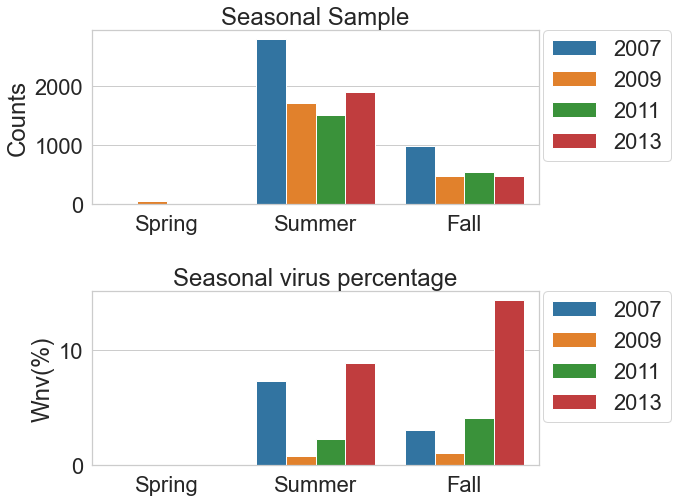

In [105]:
#sns.barplot(data=dfmerge,x="Monthofyear", y="Wnv_percent", hue="Year")
import seaborn as sns
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

#sns.set_theme(style="whitegrid")
g1=sns.barplot(x="Season", y="Sample",hue='Year', data=dfmerge,order=['Spring','Summer', 'Fall'],ax=ax[0])
#plt.ylabel('Counts')
g1.set(title="Seasonal Sample")
g1.set(ylabel='Counts')
g1.set(xlabel=None)
g1.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.subplots_adjust(hspace=0.5)

g2=sns.barplot(x="Season", y="Wnv_percent",hue='Year', data=dfmerge,order=['Spring','Summer', 'Fall'],ax=ax[1])
g2.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
#plt.ylabel('Wnv(%)')
plt.title("Seasonal virus percentage")
g2.set(ylabel='Wnv(%)')
g2.set(xlabel=None)

plt.show()

In [106]:
Month_count=df.Monthofyear.value_counts()
Month_wnv=df.groupby('Monthofyear')['WnvPresent'].sum().sort_values(ascending=False)
Month_count=Month_count.to_frame().join(Month_wnv.to_frame())
Month_count = Month_count.rename(columns={'Monthofyear': 'Total_count', 'WnvPresent': 'Wnv_count'})
Month_count['Wnv_percent']=Month_count.Wnv_count*100/Month_count.Total_count
Month_count.sort_values(by='Wnv_percent',ascending=False)

,Total_count,Wnv_count,Wnv_percent
Aug,3751,377,10.050653
Sep,2218,125,5.635708
July,2606,46,1.765157
Oct,276,2,0.724638
June,1571,1,0.063654
May,84,0,0.000000


Virus absent in May. The highest fraction was be observed in August.

In [107]:
df_month_year=df.groupby([(df.Year),(df.Monthofyear)]).mean()[['Tavg','PrecipTotal']]
df_month_year_count=df.groupby([(df.Year),(df.Monthofyear),(df.Month)])['Monthofyear'].count()
df_month_year_wnv=df.groupby([(df.Year),(df.Monthofyear),(df.Month)])['WnvPresent'].sum()
#type(df_month_year_wnv)
dfmerge = pd.concat([df_month_year_count, df_month_year_wnv], axis=1)
dfmerge = dfmerge.rename(columns={'Monthofyear': 'Sample', 'WnvPresent': 'Wnv_sample'})
dfmerge['Wnv_percent']=dfmerge.Wnv_sample*100/dfmerge.Sample
df_mergeA = df_month_year.merge(dfmerge, how='outer', left_index=True, right_index=True)
#df_merge   #.sort_values(by='Wnv_percent',ascending=False)
df_mergeA.reset_index(inplace=True)
dfgroup_monthly=df_mergeA.copy()

In [108]:
#df_mergeA["Month"] = pd.to_datetime(df_mergeA.Monthofyear, format='%b', errors='coerce').dt.month
df_mergeA = df_mergeA.sort_values(["Year", "Month"],ascending = (True, True))

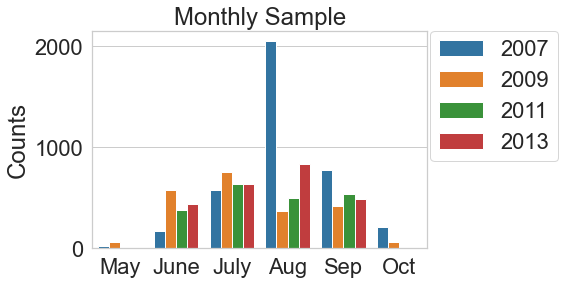

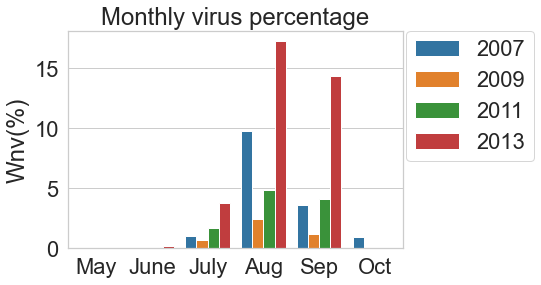

In [109]:
#sns.barplot(data=dfmerge,x="Monthofyear", y="Wnv_percent", hue="Year")
import seaborn as sns
#fig, ax = plt.subplots(2, 1, figsize=(8, 8))

#sns.set_theme(style="whitegrid")
g1=sns.barplot(x="Monthofyear", y="Sample",hue='Year', data=df_mergeA)
g1.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.title("Monthly Sample")
plt.ylabel('Counts')
g1.set(xlabel=None)
plt.show()

g2=sns.barplot(x="Monthofyear", y="Wnv_percent",hue='Year', data=df_mergeA)
g2.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.ylabel('Wnv(%)')
plt.title("Monthly virus percentage")

g2.set(xlabel=None)
plt.show()


In [110]:
Week_count=df.Week.value_counts()
Week_wnv=df.groupby('Week')['WnvPresent'].sum().sort_values(ascending=False)
Week_count=Week_count.to_frame().join(Week_wnv.to_frame())
Week_count = Week_count.rename(columns={'Week': 'Sample', 'WnvPresent': 'Wnv_sample'})
Week_count['Wnv_percent']=Week_count.Wnv_sample*100/Week_count.Sample
Week_count.reset_index(inplace=True)
Week_count=Week_count.rename(columns={'index': 'Week'})
Week_count.set_index(["Week"], inplace = True)
Week_count.sort_values(by='Wnv_percent',ascending=False)

,Sample,Wnv_sample,Wnv_percent
Week,,,
34,784,124,15.816327
36,431,53,12.296984
35,513,61,11.890838
33,804,86,10.696517
32,743,65,8.748318
37,532,37,6.954887
31,1241,51,4.109589
38,675,21,3.111111
30,738,20,2.710027


In [111]:
df_week_year_count=df.groupby([(df.Year),(df.Monthofyear),(df.Week)])['Week'].count()
df_week_year_wnv=df.groupby([(df.Year),(df.Monthofyear),(df.Week)])['WnvPresent'].sum()
##type(df_month_year_wnv)
dfmerge = pd.concat([df_week_year_count, df_week_year_wnv], axis=1)
dfmerge = dfmerge.rename(columns={'Week': 'Weekly_sample', 'WnvPresent': 'Wnv_count'})
dfmerge['Wnv_percent']=dfmerge.Wnv_count*100/dfmerge.Weekly_sample


df_week_year=df.groupby([(df.Year),(df.Monthofyear),(df.Week)]).mean()

df_mergeB = df_week_year.merge(dfmerge, how='outer', left_index=True, right_index=True)
df_mergeB.reset_index(inplace=True)
dfgroup_weekly=df_mergeB.copy()
df_mergeB = df_mergeB.sort_values(["Year", "Week"],ascending = (True, True))
df_mergeB.head()

,Year,Monthofyear,Week,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Depart,...,AvgSpeed,Relative_humidity,DewPoint_depression,WetBulb_depression,Day_of_week,Day_of_month,Month,Weekly_sample,Wnv_count,Wnv_percent
11,2007,May,22,36.240000,41.876884,-87.696170,7.920000,1.600000,0.0,10.000000,...,6.950000,55.630000,17.000000,10.000000,1.000000,29.000000,5.0,25,0,0.0
9,2007,June,23,36.950000,41.882557,-87.716228,8.200000,2.116667,0.0,-9.000000,...,7.850000,71.780000,9.000000,5.000000,1.000000,5.000000,6.0,60,0,0.0
10,2007,June,26,39.379310,41.890366,-87.717315,8.215517,2.594828,0.0,2.862069,...,7.857759,69.614138,10.715517,7.318966,2.189655,27.189655,6.0,116,0,0.0
5,2007,July,27,40.702703,41.886917,-87.717122,8.175676,3.243243,0.0,-6.000000,...,8.300000,54.410000,17.000000,8.500000,0.000000,2.000000,7.0,74,0,0.0
6,2007,July,28,41.065789,41.852237,-87.705824,8.263158,7.256579,0.0,-3.000000,...,11.049999,50.950000,19.000000,11.000000,2.000000,11.000000,7.0,152,0,0.0


In [112]:
df_mergeB.columns

Index(['Year', 'Monthofyear', 'Week', 'Block', 'Latitude', 'Longitude',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Depart',
       'Daytime_length', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat',
       'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Relative_humidity', 'DewPoint_depression',
       'WetBulb_depression', 'Day_of_week', 'Day_of_month', 'Month',
       'Weekly_sample', 'Wnv_count', 'Wnv_percent'],
      dtype='object')

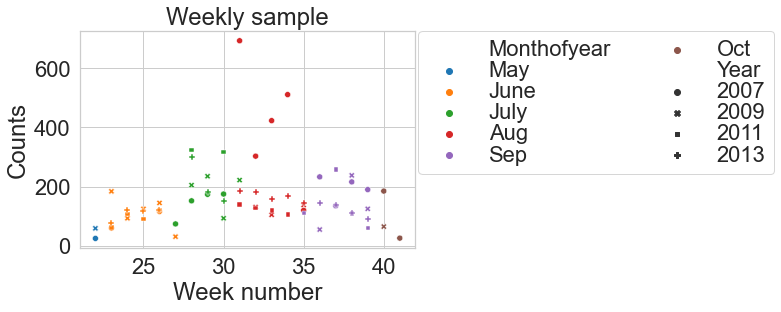

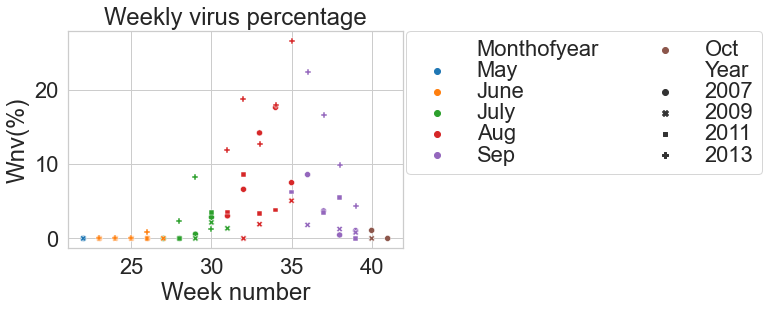

In [113]:
import seaborn as sns
#fig, ax = plt.subplots(2, 1, figsize=(8, 8))
#sns.set_theme(style="whitegrid")
figsize=(15, 8)
g3=sns.scatterplot(x="Week", y="Weekly_sample",style='Year',hue="Monthofyear", data=df_mergeB.sort_values(["Year", "Week"]))
plt.xlabel('Week number')
plt.ylabel('Counts')
plt.title("Weekly sample")
#g3.set_xticklabels(g3.get_xticklabels(),size=8)
g3.legend(bbox_to_anchor=(1.01, 1),ncol=2,labelspacing=0.05,borderaxespad=0)
plt.show()


g4=sns.scatterplot(x="Week", y="Wnv_percent",style='Year',hue="Monthofyear", data=df_mergeB.sort_values(["Year", "Week"]))
plt.title("Weekly virus percentage")
plt.xlabel('Week number')
plt.ylabel('Wnv(%)')
#g4.set_xticklabels(g4.get_xticklabels(),size=12)
g4.legend(bbox_to_anchor=(1.01, 1),ncol=2,labelspacing=0.05,borderaxespad=0)
plt.show()


In [114]:
MM=df[['Date','WnvPresent']]
MM.set_index(['Date'],inplace=True)
MM.info()
y=MM['WnvPresent'].resample('W').sum()
z=MM['WnvPresent'].resample('W').count()
Weekly_percent=y.divide(z).multiply(100)
Weekly_percent.fillna(0,inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   WnvPresent  10506 non-null  int64
dtypes: int64(1)
memory usage: 164.2 KB


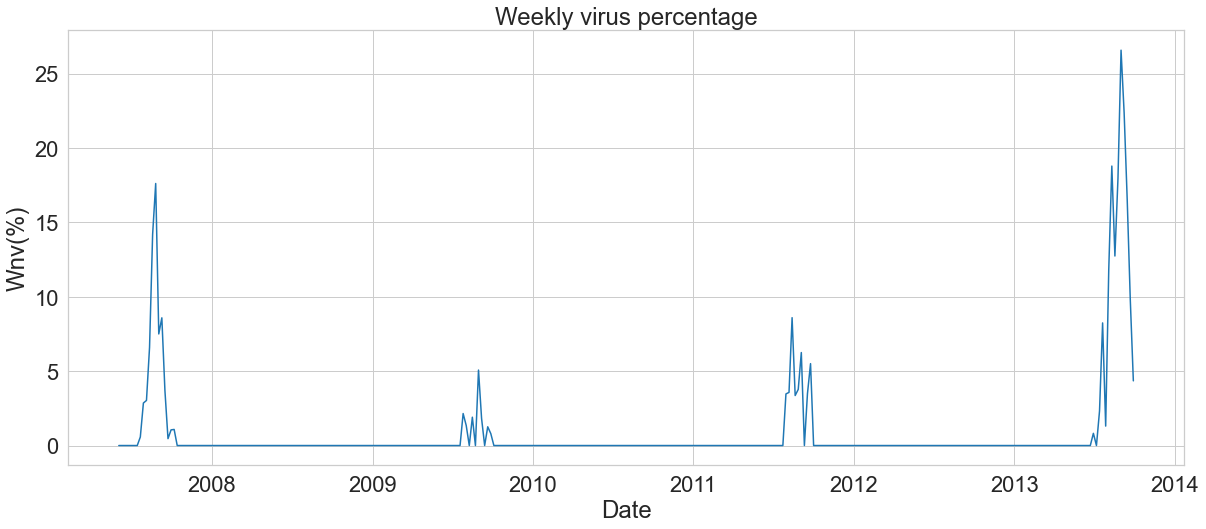

In [115]:
plt.figure(figsize=(20,8))
plt.plot(Weekly_percent)
plt.title('Weekly virus percentage')
plt.xlabel('Date')
plt.ylabel('Wnv(%)')
plt.show()

In [116]:
y=MM['WnvPresent'].resample('D').sum()
z=MM['WnvPresent'].resample('D').count()
Daily_percent=y.divide(z).multiply(100)
Daily_percent.fillna(0,inplace=True)

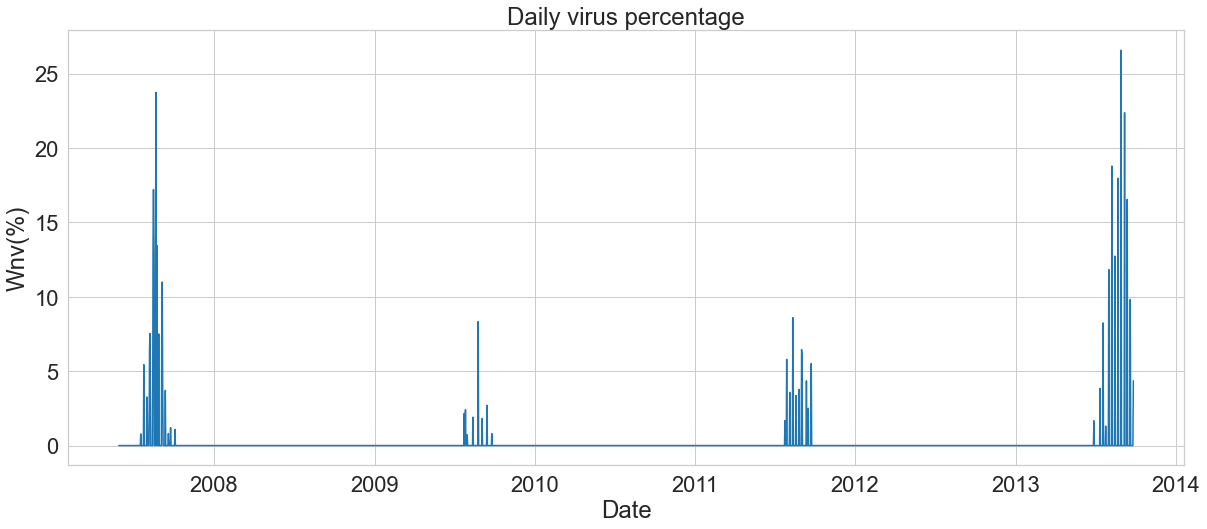

In [117]:
plt.figure(figsize=(20,8))
plt.plot(Daily_percent)
plt.title('Daily virus percentage')
plt.xlabel('Date')
plt.ylabel('Wnv(%)')
plt.show()



In [118]:
Daily_percent

Date
2007-05-29    0.000000
2007-05-30    0.000000
2007-05-31    0.000000
2007-06-01    0.000000
2007-06-02    0.000000
                ...   
2013-09-22    0.000000
2013-09-23    0.000000
2013-09-24    0.000000
2013-09-25    0.000000
2013-09-26    4.347826
Freq: D, Name: WnvPresent, Length: 2313, dtype: float64

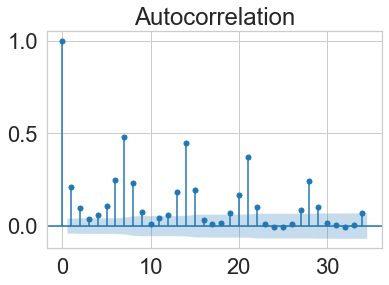

In [119]:
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Daily_percent)
plt.show()



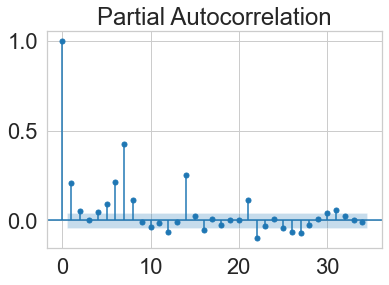

In [120]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(Daily_percent)
plt.show()

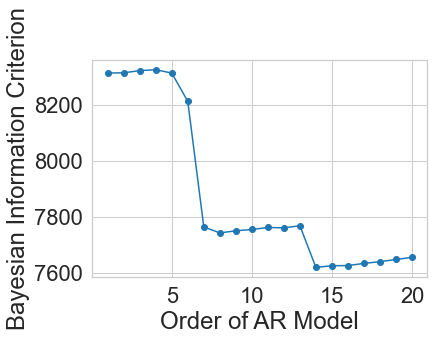

In [121]:
# Import the module for estimating an ARMA model 
from statsmodels.tsa.arima_model import ARMA
# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC 
BIC = np.zeros(22)
BIC_aic= np.zeros(22)
for p in range(22):
    mod = ARMA(Daily_percent, order=(p,0)) 
    res = mod.fit()
    # Save BIC for AR(p)
    BIC[p] = res.bic
    BIC_aic[p] = res.aic # Plot the BIC as a function of p 

plt.plot(range(1,21), BIC[1:21], marker='o') 
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()




In [122]:
Sevenday_lag=Daily_percent.diff(7)
Sevenday_lag.fillna(0,inplace=True)
Fourteenday_lag=Daily_percent.diff(14)
Fourteenday_lag.fillna(0,inplace=True)
Twentyoneday_lag=Daily_percent.diff(21)
Twentyoneday_lag.fillna(0,inplace=True)

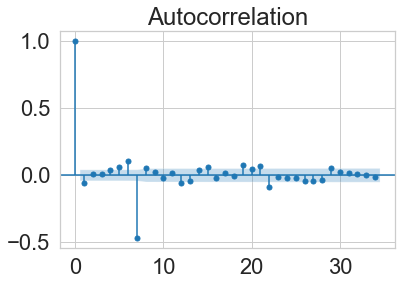

In [123]:
plot_acf(Daily_percent.diff(7).dropna())
plt.show()

In [124]:
frame = { 'Sevenday_lag': Sevenday_lag, 'Fourteenday_lag': Fourteenday_lag,'Twentyoneday_lag': Twentyoneday_lag } 
  
df_lag = pd.DataFrame(frame) 
df_lag

,Sevenday_lag,Fourteenday_lag,Twentyoneday_lag
Date,,,
2007-05-29,0.000000,0.000000,0.000000
2007-05-30,0.000000,0.000000,0.000000
2007-05-31,0.000000,0.000000,0.000000
2007-06-01,0.000000,0.000000,0.000000
2007-06-02,0.000000,0.000000,0.000000
...,...,...,...
2013-09-22,0.000000,0.000000,0.000000
2013-09-23,0.000000,0.000000,0.000000
2013-09-24,0.000000,0.000000,0.000000


In [125]:
dfgroup_yearly.drop(columns=['Sample','Wnv_sample'],inplace=True)
dfgroup_yearly

,Year,Wnv_percent
0,2007,6.192600
1,2013,9.991639
2,2009,0.844820
3,2011,2.775073


In [126]:
dfgroup_seasonal.drop(columns=['Sample','Wnv_sample'],inplace=True)
dfgroup_seasonal

,Year,Season,Wnv_percent
0,2007,Fall,3.045685
1,2007,Spring,0.000000
2,2007,Summer,7.354516
3,2009,Fall,1.035197
4,2009,Spring,0.000000
5,2009,Summer,0.820152
6,2011,Fall,4.074074
7,2011,Summer,2.311757
8,2013,Fall,14.403292
9,2013,Summer,8.866737


In [127]:
dfgroup_monthly.drop(columns=['Month','Tavg','PrecipTotal','Sample','Wnv_sample'],inplace=True)
dfgroup_monthly.head

<bound method NDFrame.head of     Year Monthofyear  Wnv_percent
0   2007         Aug     9.756098
1   2007        July     1.043478
2   2007        June     0.000000
3   2007         May     0.000000
4   2007         Oct     0.947867
5   2007         Sep     3.617571
6   2009         Aug     2.406417
7   2009        July     0.662252
8   2009        June     0.000000
9   2009         May     0.000000
10  2009         Oct     0.000000
11  2009         Sep     1.196172
12  2011         Aug     4.868154
13  2011        July     1.718750
14  2011        June     0.000000
15  2011         Sep     4.074074
16  2013         Aug    17.266187
17  2013        July     3.773585
18  2013        June     0.229358
19  2013         Sep    14.403292>

In [128]:
dfgroup_weekly.columns

Index(['Year', 'Monthofyear', 'Week', 'Block', 'Latitude', 'Longitude',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Depart',
       'Daytime_length', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat',
       'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Relative_humidity', 'DewPoint_depression',
       'WetBulb_depression', 'Day_of_week', 'Day_of_month', 'Month',
       'Weekly_sample', 'Wnv_count', 'Wnv_percent'],
      dtype='object')

In [129]:
dfgroup_weekly.drop(columns=['Monthofyear','Block', 'Latitude', 'Longitude',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Depart',
       'Daytime_length', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat',
       'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Relative_humidity', 'DewPoint_depression',
       'WetBulb_depression', 'Day_of_week', 'Day_of_month', 'Month',
       'Weekly_sample', 'Wnv_count'],inplace=True)
dfgroup_weekly

,Year,Week,Wnv_percent
0,2007,31,3.030303
1,2007,32,6.600660
2,2007,33,14.184397
3,2007,34,17.612524
4,2007,35,7.500000
...,...,...,...
60,2013,26,0.819672
61,2013,36,22.377622
62,2013,37,16.546763
63,2013,38,9.821429


In [130]:
dfgroup_yearly.rename(columns={"Wnv_percent": "Wnv_percent_yearly"},inplace=True)
new_df = pd.merge(df, dfgroup_yearly,  how='left', left_on=['Year'], right_on = ['Year'])

dfgroup_seasonal.rename(columns={"Wnv_percent": "Wnv_percent_seasonal"},inplace=True)
new_df1 = pd.merge(new_df, dfgroup_seasonal,  how='left', left_on=['Year','Season'], right_on = ['Year','Season'])

dfgroup_monthly.rename(columns={"Wnv_percent": "Wnv_percent_monthly"},inplace=True)
new_df2 = pd.merge(new_df1, dfgroup_monthly,  how='left', left_on=['Year','Monthofyear'], right_on = ['Year','Monthofyear'])



dfgroup_weekly.rename(columns={"Wnv_percent": "Wnv_percent_weekly"},inplace=True)
new_df3A = pd.merge(new_df2, dfgroup_weekly,  how='left', left_on=['Year','Week'], right_on = ['Year','Week'])


new_df3 = pd.merge(new_df3A, df_lag,  how='left', left_on=['Date'], right_on = ['Date'])




new_df3.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,Year,Season,Monthofyear,Wnv_percent_yearly,Wnv_percent_seasonal,Wnv_percent_monthly,Wnv_percent_weekly,Sevenday_lag,Fourteenday_lag,Twentyoneday_lag
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,2007,Spring,May,6.1926,0.0,0.0,0.0,0.0,0.0,0.0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,2007,Spring,May,6.1926,0.0,0.0,0.0,0.0,0.0,0.0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,2007,Spring,May,6.1926,0.0,0.0,0.0,0.0,0.0,0.0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,2007,Spring,May,6.1926,0.0,0.0,0.0,0.0,0.0,0.0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,2007,Spring,May,6.1926,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
#from pathlib import Path

#import requests
#import numpy as np
#import pandas as pd

#import pandas_profiling
#from pandas_profiling.utils.cache import cache_file
#report = dftrain.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)
#report
#profile_report = df.profile_report(explorative=True, html={'style': {'full_width': True}})
#profile_report
#profile_report.to_widgets()

In [132]:
features = [x for x in df_mergeB.columns if x not in ['Block','Day_of_week', 'Day_of_month', 'Week', 'Month', 'Year', 'Season',
       'Monthofyear','WnvPresent','Wnv_count','Wnv_percent']]

In [133]:
#def scatterplots(columns, ncol=None, figsize=(15, 8)):
def scatterplots(columns, ncol=None,figsize=(15,15)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'Wnv_percent', data=df_mergeB, alpha=0.5)
        ax.set(xlabel=col, ylabel='Wnv(%)')
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.xaxis.label.set_size(12)
        ax.yaxis.label.set_size(12)
        
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)
    #plt.savefig("Scatter.png",dpi=600)

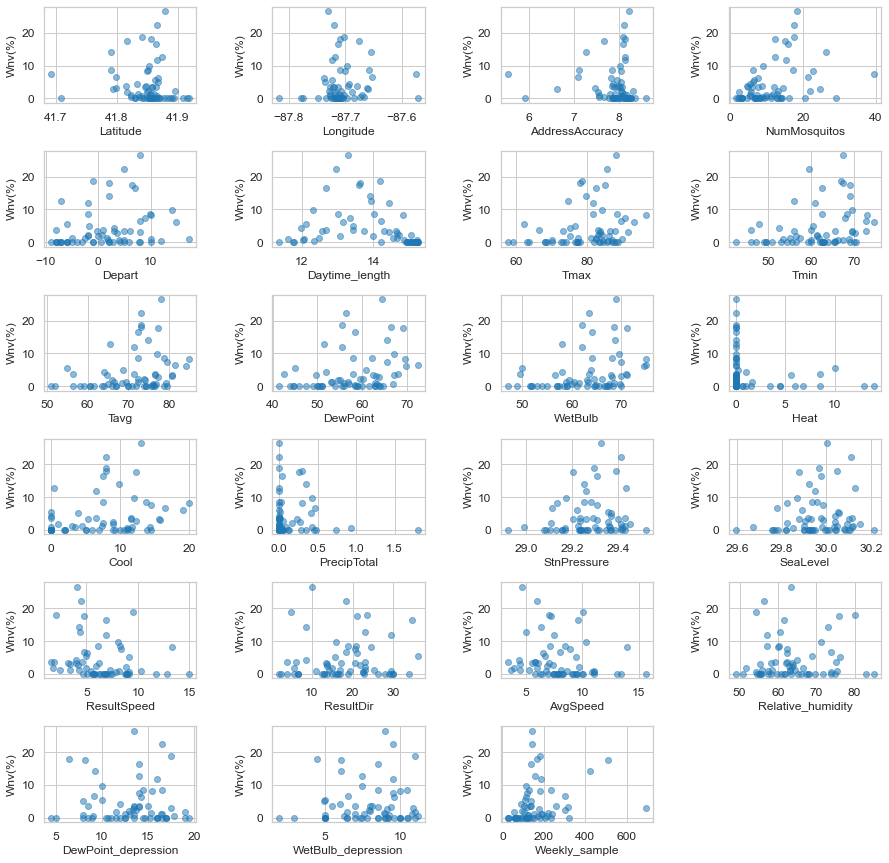

In [134]:
#scatterplots of weekly virus percentage against weather parameters
scatterplots(features, ncol=4)
plt.savefig("Scatter.png",dpi=600)

## 4. Features selection <a id='4._Features selection'></a>

In [135]:
new_df3.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
Depart                    0
Sunrise                   0
Sunset                    0
Daytime_length            0
Tmax                      0
Tmin                      0
Tavg                      0
DewPoint                  0
WetBulb                   0
Heat                      0
Cool                      0
PrecipTotal               0
StnPressure               0
SeaLevel                  0
ResultSpeed               0
ResultDir                 0
AvgSpeed                  0
Relative_humidity         0
DewPoint_depression       0
WetBulb_depression        0
Day_of_week               0
Day_of_month              0
Week                      0
Month               

In [136]:
new_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Date                    10506 non-null  datetime64[ns] 
 1   Address                 10506 non-null  object         
 2   Species                 10506 non-null  object         
 3   Block                   10506 non-null  int64          
 4   Street                  10506 non-null  object         
 5   Trap                    10506 non-null  object         
 6   AddressNumberAndStreet  10506 non-null  object         
 7   Latitude                10506 non-null  float64        
 8   Longitude               10506 non-null  float64        
 9   AddressAccuracy         10506 non-null  int64          
 10  NumMosquitos            10506 non-null  int64          
 11  WnvPresent              10506 non-null  int64          
 12  Depart                  10506 no

In [137]:
new_df3['Week'] = new_df3['Week'].astype(str).astype(int)
new_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Date                    10506 non-null  datetime64[ns] 
 1   Address                 10506 non-null  object         
 2   Species                 10506 non-null  object         
 3   Block                   10506 non-null  int64          
 4   Street                  10506 non-null  object         
 5   Trap                    10506 non-null  object         
 6   AddressNumberAndStreet  10506 non-null  object         
 7   Latitude                10506 non-null  float64        
 8   Longitude               10506 non-null  float64        
 9   AddressAccuracy         10506 non-null  int64          
 10  NumMosquitos            10506 non-null  int64          
 11  WnvPresent              10506 non-null  int64          
 12  Depart                  10506 no

In [138]:
#drop weather features exhibiting highly corrleated features retaining only one of them
# Tmax, Tmin and Tav
#Dewpoint and wetbulb
#Stnpressure and SeaLevel
#ResultSpeend and AverageSpeed
#WetBulb_depression and DewPoint_depression
#Tav and WetBulb 
columns_to_drop=['Tmax', 'Tmin', 'DewPoint','StnPressure','AvgSpeed','WetBulb_depression','WetBulb' ]
dff=new_df3.drop(columns=columns_to_drop)
#dff=df

In [139]:
dff.select_dtypes('object').columns

Index(['Address', 'Species', 'Street', 'Trap', 'AddressNumberAndStreet',
       'Season', 'Monthofyear'],
      dtype='object')

In [140]:
# drop time columns and object columns other than Species

#columns_to_drop=['Date','Address', 'Street','Trap','Sunrise','Sunset','AddressNumberAndStreet','Monthofyear','Season' ]
columns_to_drop=['Date','Address', 'Street','Trap','Sunrise','Sunset','AddressNumberAndStreet']

dff=dff.drop(columns=columns_to_drop)
#df= df.drop(['Date','Address', 'Block', 'Street','Trap','AddressNumberAndStreet', 'NumMosquitos','Monthofyear','Season' ], axis = 1)

In [141]:
#one hot encoding on species
from sklearn.preprocessing import OneHotEncoder
df_encoded =pd.get_dummies(dff, columns=['Species','Season','Monthofyear'])

In [142]:
df_encoded.columns
#df_encoded.head()
#df_encoded.info()

Index(['Block', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'Depart', 'Daytime_length', 'Tavg', 'Heat', 'Cool',
       'PrecipTotal', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'Relative_humidity', 'DewPoint_depression', 'Day_of_week',
       'Day_of_month', 'Week', 'Month', 'Year', 'Wnv_percent_yearly',
       'Wnv_percent_seasonal', 'Wnv_percent_monthly', 'Wnv_percent_weekly',
       'Sevenday_lag', 'Fourteenday_lag', 'Twentyoneday_lag',
       'Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Season_Fall', 'Season_Spring',
       'Season_Summer', 'Monthofyear_Aug', 'Monthofyear_July',
       'Monthofyear_June', 'Monthofyear_May', 'Monthofyear_Oct',
       'Monthofyear_Sep'],
      dtype='object')

In [143]:
# drop mosquito species without virus and months May where the virus was not observed
columns_to_drop=['Species_CULEX TERRITANS','Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS','Species_CULEX ERRATICUS','Monthofyear_May' ]
df_encoded=df_encoded.drop(columns=columns_to_drop)
df_encoded.columns

Index(['Block', 'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'Depart', 'Daytime_length', 'Tavg', 'Heat', 'Cool',
       'PrecipTotal', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'Relative_humidity', 'DewPoint_depression', 'Day_of_week',
       'Day_of_month', 'Week', 'Month', 'Year', 'Wnv_percent_yearly',
       'Wnv_percent_seasonal', 'Wnv_percent_monthly', 'Wnv_percent_weekly',
       'Sevenday_lag', 'Fourteenday_lag', 'Twentyoneday_lag',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Season_Fall', 'Season_Spring',
       'Season_Summer', 'Monthofyear_Aug', 'Monthofyear_July',
       'Monthofyear_June', 'Monthofyear_Oct', 'Monthofyear_Sep'],
      dtype='object')

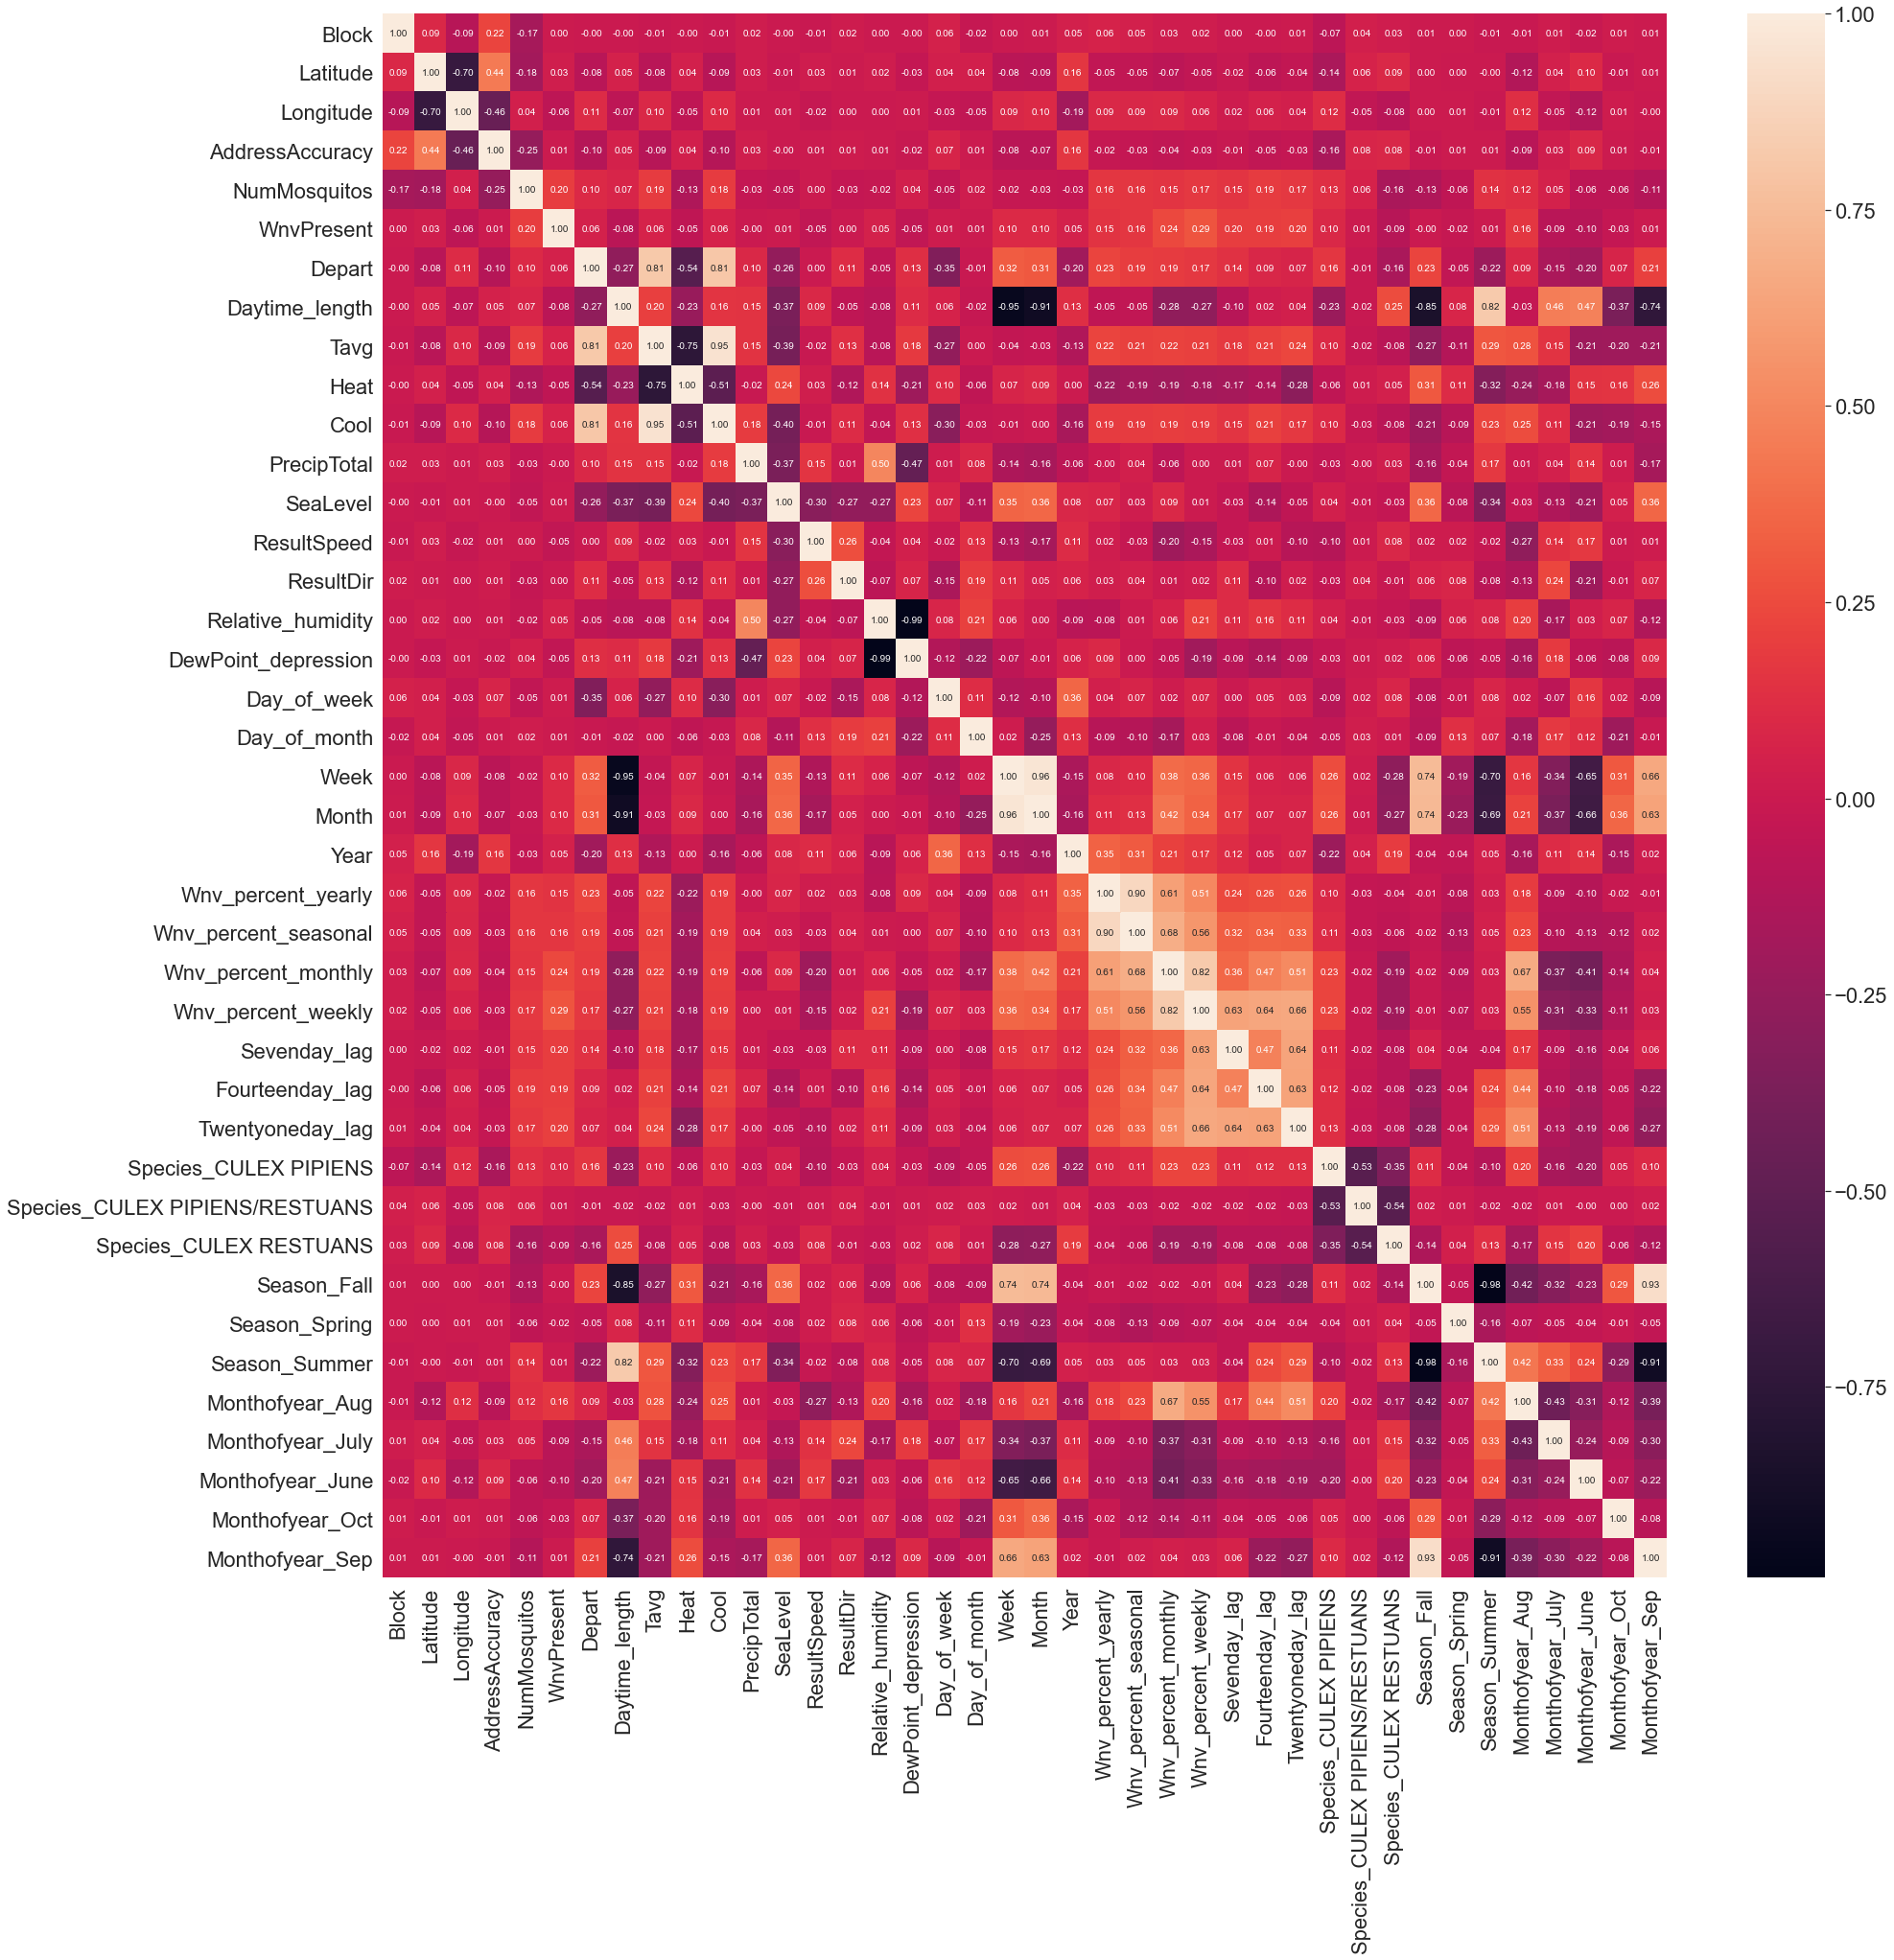

In [144]:
#Visualize correlation of target variable WnvPresent with other feathures
plt.subplots(figsize=(30,30))

corr = df_encoded.corr(method='pearson')
ax = sns.heatmap(corr, annot=True,annot_kws={'size':10}, fmt=".2f")


In [145]:
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime



In [146]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns='WnvPresent'), 
                                                    df_encoded.WnvPresent, test_size=0.3, 
                                                    random_state=47)

In [147]:
#Training virus %
print(y_train.value_counts())
print(y_train.value_counts()/len(y_train))

0    6963
1     391
Name: WnvPresent, dtype: int64
0    0.946832
1    0.053168
Name: WnvPresent, dtype: float64


In [148]:
#Test virus %
print(y_test.value_counts())
print(y_test.value_counts()/len(y_test))

0    2992
1     160
Name: WnvPresent, dtype: int64
0    0.949239
1    0.050761
Name: WnvPresent, dtype: float64


In [149]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

In [150]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
print(model_res)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
#y_pred = model_res.predict(X_test)
#y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
Random Forest: Accuracy=0.947
Random Forest: f1-score=0.935


In [151]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [152]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns='WnvPresent'), 
                                                    df_encoded.WnvPresent, test_size=0.3, 
                                                    random_state=47)

In [153]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7354 entries, 4381 to 5255
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Block                           7354 non-null   int64  
 1   Latitude                        7354 non-null   float64
 2   Longitude                       7354 non-null   float64
 3   AddressAccuracy                 7354 non-null   int64  
 4   NumMosquitos                    7354 non-null   int64  
 5   Depart                          7354 non-null   int64  
 6   Daytime_length                  7354 non-null   float64
 7   Tavg                            7354 non-null   float64
 8   Heat                            7354 non-null   float64
 9   Cool                            7354 non-null   float64
 10  PrecipTotal                     7354 non-null   float32
 11  SeaLevel                        7354 non-null   float32
 12  ResultSpeed                    

In [154]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    #print("justmiss", justmiss)
    #print("notmiss", notmiss)
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            #print("I am here 1",r, n,len(d2))
            n = n - 1 
            
        except Exception as e:
            n = n - 1
            #print("I am here e",n)

    if len(d2) == 1:
        #print("I am second step ",r, n)
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        #print(justmiss.count().Y)
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    #print("hi",d3.IV )
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                #print("Number and unique value greater than 2")
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                #print("I am here 2")
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [155]:
final_iv, IV = data_vars(X_train, y_train)


Block
0   -0.037259
1    0.036544
dtype: float64
Latitude
0   -0.133451
1    0.121575
dtype: float64
Longitude
0    0.197940
1   -0.241712
dtype: float64
AddressAccuracy
0    0.002923
1   -0.004730
dtype: float64
NumMosquitos
0   -1.934151
1   -0.935854
2    0.164444
3    0.980866
dtype: float64
Depart
0   -0.370716
1    0.130365
2    0.190995
dtype: float64
Daytime_length
0    0.565881
1    0.136170
2   -2.246854
dtype: float64
Tavg
0   -0.092446
1    0.088111
dtype: float64
Heat
0    0.097550
1   -1.370027
dtype: float64
Cool
0   -0.092446
1    0.088111
dtype: float64
PrecipTotal
0    0.027223
1        -inf
dtype: float64
SeaLevel


divide by zero encountered in log


0    0.001051
1   -0.001206
dtype: float64
ResultSpeed
0    0.160421
1    0.044622
2   -0.252848
dtype: float64
ResultDir
0   -0.045285
1    0.049206
dtype: float64
Relative_humidity
0   -0.208012
1   -0.071127
2    0.241500
dtype: float64
DewPoint_depression
0    0.340495
1   -0.045541
2   -0.100235
3   -0.346464
dtype: float64
Day_of_week
0    0.164329
1   -0.369463
dtype: float64
Day_of_month
0   -0.084008
1   -0.016416
2    0.102381
dtype: float64
Week
0   -1.227932
1    0.575564
dtype: float64
Month
0   -0.034459
1    0.104621
dtype: float64
Year
0   -0.225676
1    0.243313
dtype: float64
Wnv_percent_yearly
0   -1.028629
1    0.170003
2    0.658623
dtype: float64
Wnv_percent_seasonal
0   -1.838029
1   -0.966078
2   -0.281203
3    0.328995
4    0.466322
5    1.217110
dtype: float64
Wnv_percent_monthly
0   -4.208751
1   -2.013694
2   -1.557548
3   -0.350764
4   -0.336715
5    0.539569
6    1.217110
7    1.245779
dtype: float64
Wnv_percent_weekly
0   -3.570812
1   -0.693983
2    0.99

divide by zero encountered in log


In [156]:
#X_train.dtypes.index
#pd.qcut(X_train['NumMosquitos'],4)
#X_train.Monthofyear_Aug.unique()

In [157]:
X_train.head()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,Depart,Daytime_length,Tavg,Heat,Cool,...,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Season_Fall,Season_Spring,Season_Summer,Monthofyear_Aug,Monthofyear_July,Monthofyear_June,Monthofyear_Oct,Monthofyear_Sep
4381,61,41.991429,-87.747113,8,3,7,15.22,78.5,0.0,13.5,...,0,1,0,0,1,0,0,1,0,0
8001,77,41.754676,-87.612922,9,1,-6,12.13,55.0,10.0,0.0,...,0,1,1,0,0,0,0,0,0,1
8465,22,41.801179,-87.679447,8,4,6,15.22,78.0,0.0,13.0,...,0,1,0,0,1,0,0,1,0,0
8840,58,41.987280,-87.666066,8,50,-2,15.02,71.0,0.0,6.0,...,1,0,0,0,1,0,1,0,0,0
1062,30,41.836644,-87.677737,8,5,8,14.43,80.5,0.0,15.5,...,0,0,0,0,1,1,0,0,0,0


In [158]:
#display(df_encoded.PrecipTotal.unique())
#display(df_encoded['Species_CULEX RESTUANS'].unique())
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,Block,10.000000,33.000000,3702,190,0.051324,3512,0.948676,0.485934,0.504380,-0.037259,0.001361
1,Block,34.000000,98.000000,3652,201,0.055038,3451,0.944962,0.514066,0.495620,0.036544,0.001361
2,Latitude,41.644612,41.857402,3715,174,0.046837,3541,0.953163,0.445013,0.508545,-0.133451,0.016202
3,Latitude,41.862292,42.017430,3639,217,0.059632,3422,0.940368,0.554987,0.491455,0.121575,0.016202
4,Longitude,-87.930995,-87.696269,3684,236,0.064061,3448,0.935939,0.603581,0.495189,0.197940,0.047655
...,...,...,...,...,...,...,...,...,...,...,...,...
98,Monthofyear_June,1.000000,1.000000,1093,1,0.000915,1092,0.999085,0.002558,0.156829,-4.116108,0.660919
99,Monthofyear_Oct,0.000000,0.000000,7160,389,0.054330,6771,0.945670,0.994885,0.972426,0.022833,0.038350
100,Monthofyear_Oct,1.000000,1.000000,194,2,0.010309,192,0.989691,0.005115,0.027574,-1.684690,0.038350
101,Monthofyear_Sep,0.000000,0.000000,5810,291,0.050086,5519,0.949914,0.744246,0.792618,-0.062971,0.013188


In [159]:
IV

,VAR_NAME,IV
0,AddressAccuracy,0.000014
1,Block,0.001361
2,Cool,0.008140
3,Day_of_month,0.005781
4,Day_of_week,0.060408
5,Daytime_length,0.831386
6,Depart,0.058006
7,DewPoint_depression,0.061668
8,Fourteenday_lag,0.592182
9,Heat,0.132215


In [160]:
#features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
display(X2.shape)
X2.head()


(7354, 20)

,Day_of_week,Depart,DewPoint_depression,Fourteenday_lag,Heat,Latitude,Longitude,Monthofyear_Aug,Monthofyear_July,Monthofyear_June,Monthofyear_Oct,Monthofyear_Sep,Relative_humidity,ResultSpeed,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Week,Wnv_percent_seasonal,Wnv_percent_yearly,Year
4381,4,7,18.0,0.000000,0.0,41.991429,-87.747113,0,0,1,0,0,54.10,6.40,0,1,26,0.820152,0.844820,2009
8001,4,-6,10.0,5.504587,10.0,41.754676,-87.612922,0,0,0,0,1,68.95,5.00,0,1,38,4.074074,2.775073,2011
8465,3,6,12.0,0.000000,0.0,41.801179,-87.679447,0,0,1,0,0,66.69,6.65,0,1,26,8.866737,9.991639,2013
8840,4,-2,17.5,2.179487,0.0,41.987280,-87.666066,0,1,0,0,0,53.99,4.05,0,0,28,8.866737,9.991639,2013
1062,2,8,18.0,2.491594,0.0,41.836644,-87.677737,1,0,0,0,0,54.38,2.80,1,0,31,7.354516,6.192600,2007


In [161]:
display(X2.shape[1])
for i in range(X2.shape[1]):
    print((i, variance_inflation_factor(X2.values, i) ))
    #print(variance_inflation_factor(X2.values, i) )


20

(0, 6.190649138875347)
(1, 4.429358438096422)
(2, 2438.7874134795884)
(3, 1.67355379962722)
(4, 2.627862557820661)
(5, 253510.81318118432)
(6, 1130593.0104415175)
(7, 84.6395246903354)
(8, 44.90671630942248)
(9, 21.006822755686954)
(10, 11.37039455182333)
(11, 71.08086181516038)
(12, 9994.823872591256)
(13, 6.216925866122867)
(14, 1.670973804045202)
(15, 1.6532487637248967)
(16, 849.4618940999234)
(17, 19.393504259861047)
(18, 22.237912911348673)
(19, 657436.1566283331)


In [162]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing Longitude with VIF of 1130593.010442
Iteration # 2
Removing Year with VIF of 157646.305927
Iteration # 3
Removing Latitude with VIF of 19829.604924
Iteration # 4
Removing Week with VIF of 766.690406
Iteration # 5
Removing Relative_humidity with VIF of 71.767636
Iteration # 6
Removing Wnv_percent_yearly with VIF of 21.054425
Iteration # 7
Removing DewPoint_depression with VIF of 13.060385
Iteration # 8
Removing ResultSpeed with VIF of 5.781421
Iteration # 9
Removing Day_of_week with VIF of 5.512340
Iteration # 10
Complete


In [163]:
X_train=final_df
display(len(X_train.columns))
display(X_train.columns)
X_train.head()

11

Index(['Depart', 'Fourteenday_lag', 'Heat', 'Monthofyear_Aug',
       'Monthofyear_July', 'Monthofyear_June', 'Monthofyear_Oct',
       'Monthofyear_Sep', 'Species_CULEX PIPIENS', 'Species_CULEX RESTUANS',
       'Wnv_percent_seasonal'],
      dtype='object')

,Depart,Fourteenday_lag,Heat,Monthofyear_Aug,Monthofyear_July,Monthofyear_June,Monthofyear_Oct,Monthofyear_Sep,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Wnv_percent_seasonal
4381,7,0.000000,0.0,0,0,1,0,0,0,1,0.820152
8001,-6,5.504587,10.0,0,0,0,0,1,0,1,4.074074
8465,6,0.000000,0.0,0,0,1,0,0,0,1,8.866737
8840,-2,2.179487,0.0,0,1,0,0,0,0,0,8.866737
1062,8,2.491594,0.0,1,0,0,0,0,1,0,7.354516


## 5. Data modeling <a id='5._Data modeling'></a>

In [164]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


In [165]:
X_test=X_test[X_train.columns]
X_test.head()

,Depart,Fourteenday_lag,Heat,Monthofyear_Aug,Monthofyear_July,Monthofyear_June,Monthofyear_Oct,Monthofyear_Sep,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Wnv_percent_seasonal
8876,10,8.241758,0.0,0,1,0,0,0,0,0,8.866737
2468,9,16.214125,0.0,1,0,0,0,0,1,0,7.354516
6763,5,0.000000,0.0,0,1,0,0,0,1,0,2.311757
2205,7,10.682562,0.0,1,0,0,0,0,1,0,7.354516
4667,-3,0.000000,0.0,0,1,0,0,0,0,0,0.820152


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Features [0.15190596 0.30132069 0.02836294 0.05175889 0.03945925 0.08745622
 0.00429754 0.03676746 0.052646   0.06999907 0.17602598]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


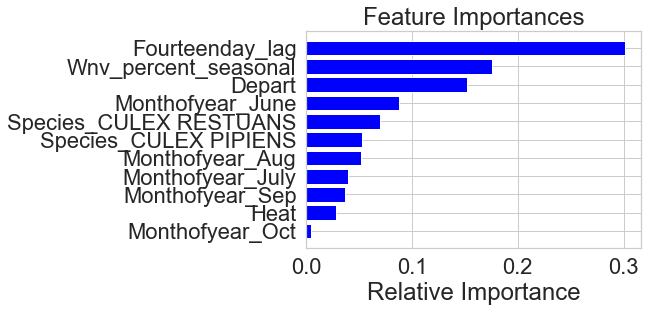

[[1756 1236]
 [  27  133]]


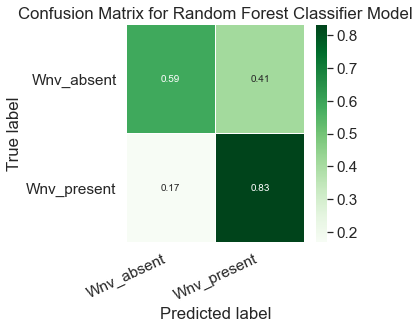

In [166]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42, max_depth=50, class_weight=dict({1:48, 0:1}), verbose=2)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred1 = rf.predict(X_test)


print("Features",rf.feature_importances_)

importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



roc1 = roc_auc_score(y_test, y_pred1)

roc1

#conf1 = confusion_matrix(y_test, y_pred1)
#conf1

print(confusion_matrix(y_test, y_pred1))
matrix = confusion_matrix(y_test, y_pred1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Classifier Model')
plt.show()



In [167]:
# Import the model we are using
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Instantiate model with 100 decision trees
xgb = XGBClassifier(n_estimators = 10, max_depth=30, max_delta_step=4, scale_pos_weight=49, random_state = 42, verbosity=2, n_jobs=-1, oob_score=True)
# Train the model on training data
xgb.fit(X_train, y_train)

y_pred3 = xgb.predict(X_test)

roc3 = roc_auc_score(y_test, y_pred3)

roc3


[20:06:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=14
[20:06:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=14
[20:06:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=14
[20:06:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=13
[20:06:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=13
[20:06:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=15
[20:06:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=18
[20:06:05] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=18
[20:06:05] INFO: src/tree/updater_prune.

0.7116811497326204

[[1622 1370]
 [  19  141]]


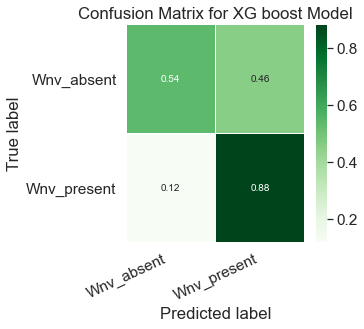

In [168]:
#conf3 = confusion_matrix(y_test, y_pred3)
#conf3
print(confusion_matrix(y_test, y_pred3))
matrix = confusion_matrix(y_test, y_pred3)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
#print(matrix)


# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()




In [169]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.99      0.54      0.70      2992
           1       0.09      0.88      0.17       160

    accuracy                           0.56      3152
   macro avg       0.54      0.71      0.43      3152
weighted avg       0.94      0.56      0.67      3152



0.7116811497326204


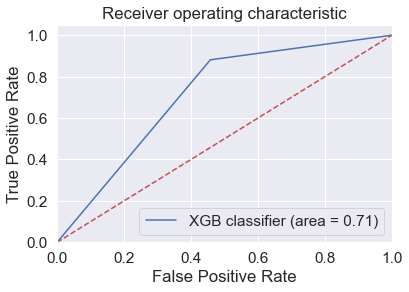

In [170]:
roc3 = roc_auc_score(y_test, y_pred3)
print(roc3)
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)

plt.figure()
plt.plot(fpr, tpr, label='XGB classifier (area = %0.2f)' % roc3 )
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
  

In [171]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, \
                       model, param_grid, cv=10, scoring_fit='roc_auc', do_probabilities=False):
                       #model, param_grid, cv=10, scoring_fit='ne_mean_squared_error', do_probabilities=False):
                       
    gs = GridSearchCV(estimator=model, \
                      param_grid=param_grid, \
                      cv=cv, \
                      n_jobs=-1, \
                      scoring=scoring_fit, \
                      verbose=2)
    
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test)
    else:
        pred = fitted_model.predict(X_test)
    return fitted_model, pred

In [172]:
param_grid = {'eta': [0.01, 0.05, 0.1], \
              'max_depth': [9, 10, 11], \
              'scale_pos_weight': [49, 50, 51], \
              'max_delta_step': [4, 6, 8], \
              'grow_policy':['depthwise', 'losswise']}

#model = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state = 42, verbosity=2)
model = XGBClassifier(n_jobs=-1, random_state = 42, verbosity=2)

In [173]:
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=5, scoring_fit='roc_auc')


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 485 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  2.2min finished


[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: t

[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tre

In [174]:
print(model.best_score_)
print(model.best_params_)

0.8099664248265587
{'eta': 0.01, 'grow_policy': 'depthwise', 'max_delta_step': 4, 'max_depth': 9, 'scale_pos_weight': 50}


In [175]:
#xgb = XGBClassifier(eta=0.01, max_delta_step=4, max_depth=9,grow_policy='depthwise', scale_pos_weight=50, n_jobs=-1, random_state = 42, verbosity=2,scoring_fit='roc_auc', do_probabilities=False)
#xgb.fit(X_train, y_train)

xgb = XGBClassifier(eta=0.01, max_delta_step=4, max_depth=9,grow_policy='depthwise',scoring_fit='roc_auc', scale_pos_weight=50, n_jobs=-1, random_state = 42, verbosity=2)
xgb.fit(X_train, y_train)


[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=9
[20:08:18] INFO: src/tree/updater_prune.cc:74: t

[20:08:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[20:08:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=9
[20:08:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=9
[20:08:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=9
[20:08:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=9
[20:08:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[20:08:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=9
[20:08:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=9
[20:08:19] INFO: src/tree/updater_prune.cc:74: t

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
              grow_policy='depthwise', learning_rate=0.1, max_delta_step=4,
              max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=50,
              scoring_fit='roc_auc', seed=None, silent=None, subsample=1,
              verbosity=2)

Test 0.7125167112299465


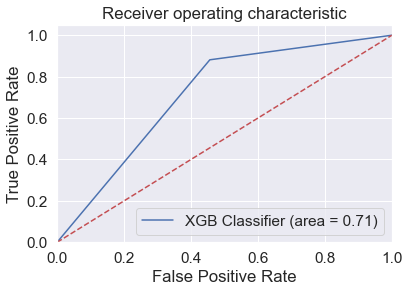

In [176]:
y_pred = xgb.predict(X_test)

roc = roc_auc_score(y_test, y_pred)

print("Test",roc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, label='XGB Classifier (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

[[1627 1365]
 [  19  141]]


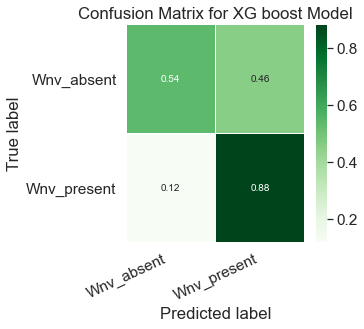

In [177]:
y_pred=pred
print(confusion_matrix(y_test, y_pred))
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()



In [178]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.54      0.70      2992
           1       0.09      0.88      0.17       160

    accuracy                           0.56      3152
   macro avg       0.54      0.71      0.44      3152
weighted avg       0.94      0.56      0.67      3152



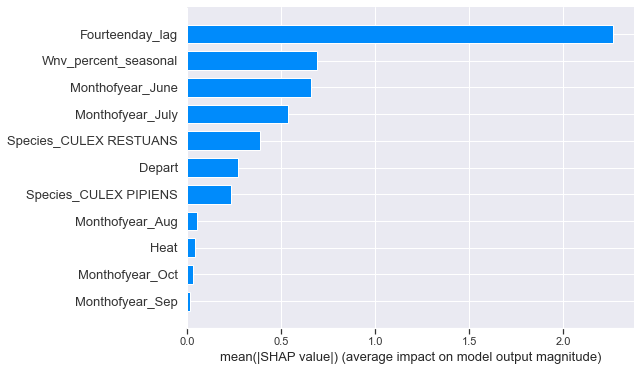

In [179]:
import shap
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

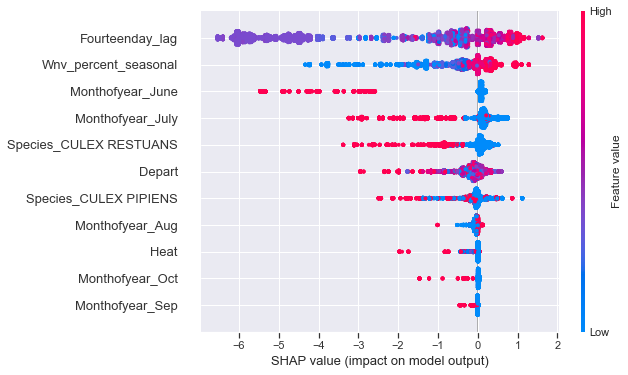

In [180]:
shap.summary_plot(shap_values, X_train)


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


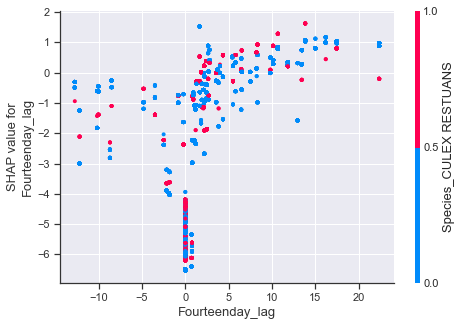

In [181]:
shap.dependence_plot("Fourteenday_lag", shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


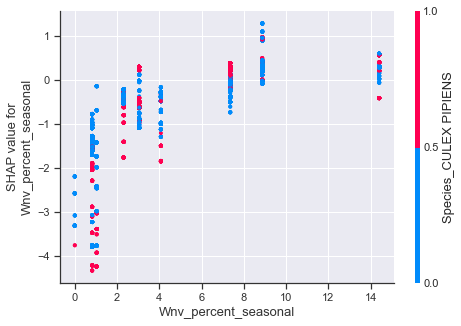

In [182]:
shap.dependence_plot("Wnv_percent_seasonal", shap_values, X_train)

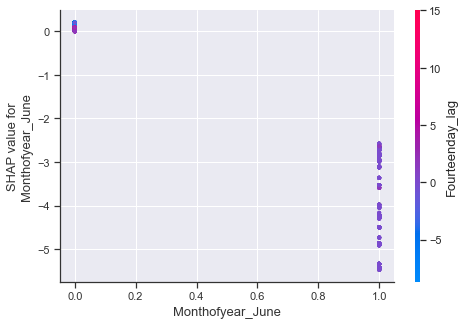

In [183]:
shap.dependence_plot("Monthofyear_June", shap_values, X_train)

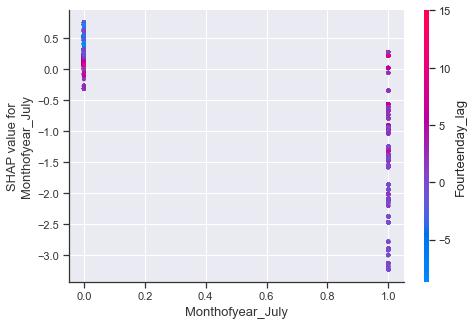

In [184]:
shap.dependence_plot("Monthofyear_July", shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


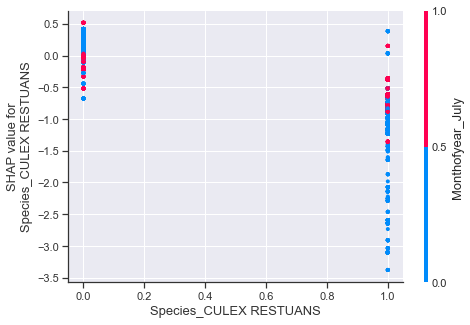

In [185]:
shap.dependence_plot("Species_CULEX RESTUANS", shap_values, X_train) 

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


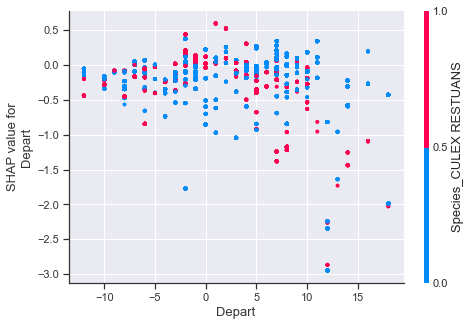

In [186]:
shap.dependence_plot("Depart", shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


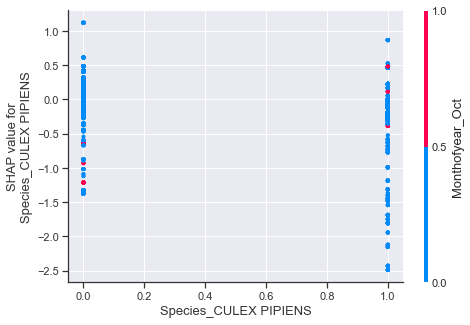

In [187]:
shap.dependence_plot("Species_CULEX PIPIENS", shap_values, X_train) 

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


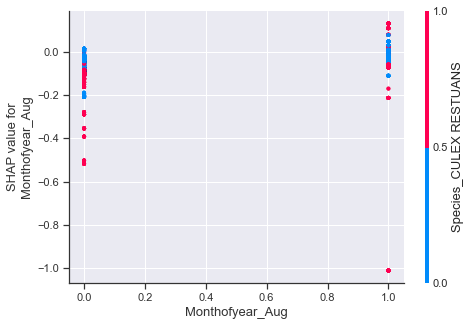

In [188]:
shap.dependence_plot("Monthofyear_Aug", shap_values, X_train)

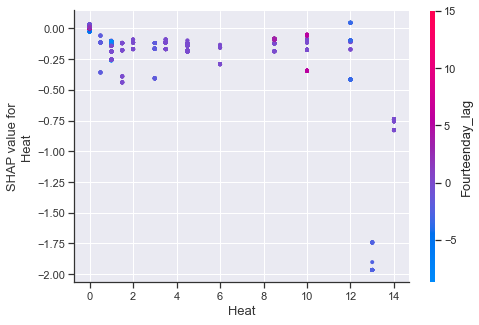

In [189]:
shap.dependence_plot("Heat", shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


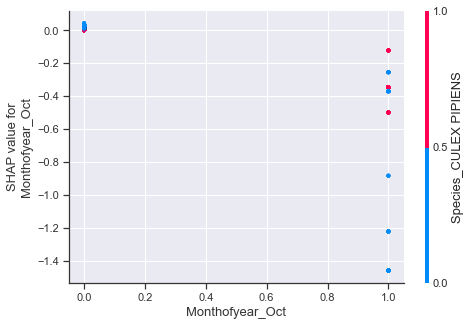

In [190]:
shap.dependence_plot("Monthofyear_Oct", shap_values, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


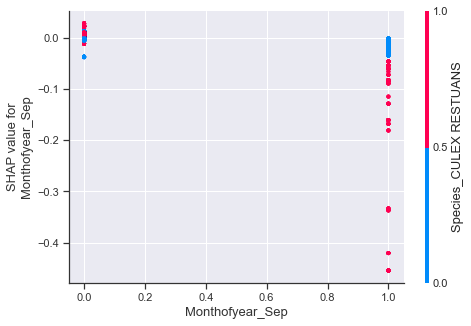

In [191]:
shap.dependence_plot("Monthofyear_Sep", shap_values, X_train)

## 6. Data modeling with equal proportion of presence and absence of virus<a id='6._Data modeling with equal proportion of presence and absence of virus'></a>

In [192]:
Virus_df=df_encoded[df_encoded.WnvPresent==1]
display(Virus_df.shape)
No_Virus_df=df_encoded[df_encoded.WnvPresent==0]

No_Virus_df_sample=No_Virus_df.sample(n = Virus_df.shape[0]) 
display(No_Virus_df_sample.shape)


Equal_sample=pd.concat([Virus_df,No_Virus_df_sample])
Equal_sample
#X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns='WnvPresent'), 
#                                                    df_encoded.WnvPresent, test_size=0.3, 
#                                                    random_state=47)

(551, 40)

(551, 40)

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Depart,Daytime_length,Tavg,Heat,...,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Season_Fall,Season_Spring,Season_Summer,Monthofyear_Aug,Monthofyear_July,Monthofyear_June,Monthofyear_Oct,Monthofyear_Sep
553,38,41.686398,-87.531635,8,50,1,3,14.87,77.0,0.0,...,1,0,0,0,1,0,1,0,0,0
603,12,41.673408,-87.599862,5,50,1,4,14.67,77.5,0.0,...,1,0,0,0,1,0,1,0,0,0
611,12,41.673408,-87.599862,5,50,1,4,14.67,77.5,0.0,...,1,0,0,0,1,0,1,0,0,0
618,12,41.673408,-87.599862,5,50,1,4,14.67,77.5,0.0,...,0,0,0,0,1,0,1,0,0,0
660,12,41.673408,-87.599862,5,50,1,4,14.67,77.5,0.0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6393,12,41.673408,-87.599862,5,1,0,2,15.20,76.0,0.0,...,0,0,0,0,1,0,0,1,0,0
5233,14,41.906638,-87.701431,9,2,0,-4,14.22,70.0,0.0,...,0,0,0,0,1,1,0,0,0,0
3076,15,41.907645,-87.760886,8,10,0,-8,12.68,56.5,8.5,...,0,0,1,0,0,0,0,0,0,1
4120,11,41.903002,-87.688267,8,13,0,-6,15.18,61.5,3.5,...,1,0,0,0,1,0,0,1,0,0


In [193]:
X_trainA, X_testA, y_trainA, y_testA = train_test_split(Equal_sample.drop(columns='WnvPresent'), 
                                                    Equal_sample.WnvPresent, test_size=0.3, 
                                                    random_state=47)

In [194]:
final_iv, IV = data_vars(X_trainA, y_trainA)

Block
0   -0.079935
1    0.083296
dtype: float64
Latitude
0   -0.075107
1    0.076246
dtype: float64
Longitude
0    0.152433
1   -0.153786
dtype: float64
AddressAccuracy
0    0.059171
1   -0.086440
dtype: float64
NumMosquitos
0   -1.609532
1   -0.188020
2    0.869771
3    0.921522
dtype: float64
Depart
0   -0.400093
1    0.204086
2    0.210204
dtype: float64
Daytime_length
0    0.454967
1   -0.457772
dtype: float64
Tavg
0   -0.169447
1    0.201864
dtype: float64
Heat
0    0.130434
1   -1.663926
dtype: float64
Cool
0   -0.169447
1    0.201864
dtype: float64
PrecipTotal
0    0.010895
1   -1.663926
dtype: float64
SeaLevel
0    0.073345
1   -0.088974
dtype: float64
ResultSpeed
0    0.132098
1    0.082087
2   -0.223565
dtype: float64
ResultDir
0   -0.031674
1    0.006965
2    0.029282
dtype: float64
Relative_humidity
0   -0.315502
1   -0.164836
2    0.500509
dtype: float64
DewPoint_depression
0    0.409545
1   -0.145085
2   -0.289945
dtype: float64
Day_of_week
0    0.135866
1   -0.334327
dt

divide by zero encountered in log


In [195]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_trainA[features]
display(X2.shape)
X2.head()


X1A = X2._get_numeric_data()
final_dfA, final_vifA = iterate_vif(X1A)





(771, 25)

Iteration # 1


divide by zero encountered in double_scalars


Removing Cool with VIF of inf
Iteration # 2
Removing Monthofyear_Aug with VIF of inf
Iteration # 3
Removing Month with VIF of 4397953.550649
Iteration # 4
Removing Longitude with VIF of 691567.176032
Iteration # 5


divide by zero encountered in double_scalars


Removing Year with VIF of 72335.211924
Iteration # 6
Removing Week with VIF of 34183.358238
Iteration # 7
Removing Daytime_length with VIF of 23874.676492
Iteration # 8
Removing Tavg with VIF of 3677.503832
Iteration # 9
Removing Season_Summer with VIF of 302.493778
Iteration # 10
Removing Wnv_percent_yearly with VIF of 24.420293
Iteration # 11
Removing Relative_humidity with VIF of 21.389178
Iteration # 12
Removing DewPoint_depression with VIF of 9.979447
Iteration # 13
Removing Day_of_week with VIF of 5.433128
Iteration # 14
Complete


In [196]:
X_trainA=final_dfA
display(len(X_trainA.columns))
display(X_trainA.columns)
X_trainA.head()



12

Index(['Day_of_month', 'Depart', 'Heat', 'Monthofyear_July',
       'Monthofyear_June', 'Monthofyear_Oct', 'PrecipTotal', 'ResultSpeed',
       'Season_Fall', 'Species_CULEX PIPIENS', 'Species_CULEX RESTUANS',
       'Wnv_percent_seasonal'],
      dtype='object')

,Day_of_month,Depart,Heat,Monthofyear_July,Monthofyear_June,Monthofyear_Oct,PrecipTotal,ResultSpeed,Season_Fall,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Wnv_percent_seasonal
10157,6,5,0.0,0,0,0,0.000,4.50,1,0,0,14.403292
7771,12,10,0.0,0,0,0,0.000,9.85,1,1,0,4.074074
1080,1,8,0.0,0,0,0,0.000,2.80,0,0,1,7.354516
9846,22,2,0.0,0,0,0,0.295,2.00,0,0,0,8.866737
10014,29,8,0.0,0,0,0,0.000,4.05,0,1,0,8.866737


In [197]:
#X_trainA=X_trainA[X_train.columns]
#X_testA=X_testA[X_train.columns]


X_testA=X_testA[X_trainA.columns]
X_testA.head()

,Day_of_month,Depart,Heat,Monthofyear_July,Monthofyear_June,Monthofyear_Oct,PrecipTotal,ResultSpeed,Season_Fall,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Wnv_percent_seasonal
6821,25,7,0.0,1,0,0,0.0050,2.75,0,0,1,2.311757
8158,7,-6,4.5,0,1,0,0.0025,9.15,0,0,1,8.866737
8403,21,5,0.0,0,1,0,0.4500,7.50,0,0,1,8.866737
768,27,3,0.0,1,0,0,0.1050,2.10,0,0,1,7.354516
8715,12,-2,0.0,1,0,0,0.0000,4.05,0,0,1,8.866737


In [198]:
param_grid = {'eta': [0.01, 0.05, 0.1], \
              'max_depth': [9, 10, 11], \
              'scale_pos_weight': [49, 50, 51], \
              'max_delta_step': [4, 6, 8], \
              'grow_policy':['depthwise', 'losswise']}

#model = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state = 42, verbosity=2)
model = XGBClassifier(n_jobs=-1, random_state = 42, verbosity=2)

model, pred = algorithm_pipeline(X_trainA, X_testA, y_trainA, y_testA, model, param_grid, cv=5, scoring_fit='roc_auc')



Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:    5.0s


[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pr

[Parallel(n_jobs=-1)]: Done 795 out of 810 | elapsed:   15.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   15.5s finished


In [199]:
print(model.best_score_)
print(model.best_params_)

0.8081029535864979
{'eta': 0.01, 'grow_policy': 'depthwise', 'max_delta_step': 4, 'max_depth': 10, 'scale_pos_weight': 51}


In [200]:
xgb = XGBClassifier(eta=0.01, max_delta_step=4, max_depth=9,grow_policy='depthwise',scoring_fit='roc_auc', scale_pos_weight=50, n_jobs=-1, random_state = 42, verbosity=2)
xgb.fit(X_trainA, y_trainA)




[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[20:08:48] INFO: src/tree/updater_prune.cc:74: tree prun

[20:08:48] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
              grow_policy='depthwise', learning_rate=0.1, max_delta_step=4,
              max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=50,
              scoring_fit='roc_auc', seed=None, silent=None, subsample=1,
              verbosity=2)

In [201]:
y_predA =xgb.predict(X_testA)

roc = roc_auc_score(y_testA, y_predA)

print("Test",roc)

Test 0.6764296187683285


[[ 78  98]
 [ 14 141]]


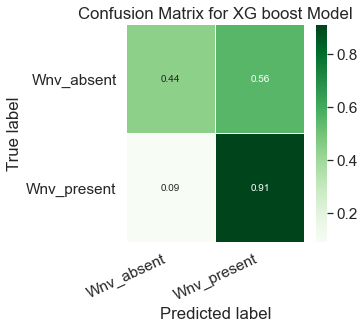

In [202]:

print(confusion_matrix(y_testA, y_predA))
matrix = confusion_matrix(y_testA, y_predA)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(4,4))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Wnv_absent', 'Wnv_present']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for XG boost Model')
plt.show()

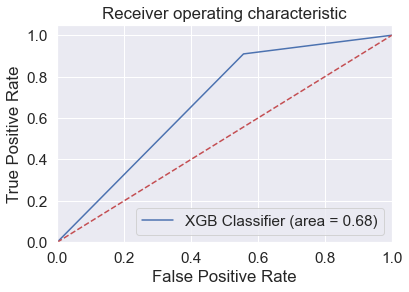

In [203]:

fpr, tpr, thresholds = roc_curve(y_testA, y_predA)

plt.figure()
plt.plot(fpr, tpr, label='XGB Classifier (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()




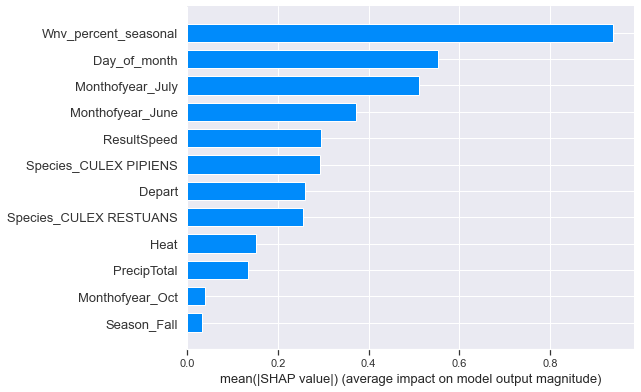

In [204]:
import shap
shap_values = shap.TreeExplainer(xgb).shap_values(X_trainA)
shap.summary_plot(shap_values, X_trainA, plot_type="bar")

In [205]:
X_trainA.columns

Index(['Day_of_month', 'Depart', 'Heat', 'Monthofyear_July',
       'Monthofyear_June', 'Monthofyear_Oct', 'PrecipTotal', 'ResultSpeed',
       'Season_Fall', 'Species_CULEX PIPIENS', 'Species_CULEX RESTUANS',
       'Wnv_percent_seasonal'],
      dtype='object')

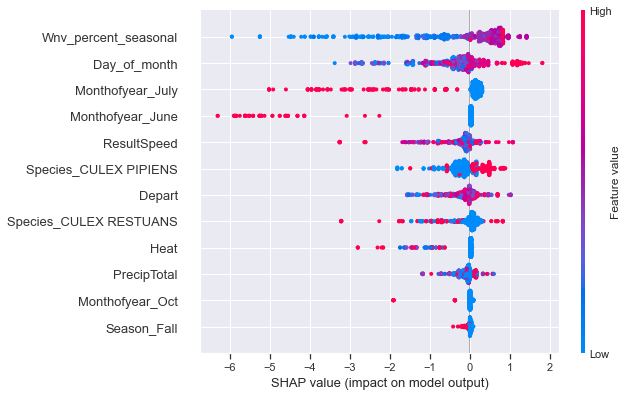

In [206]:
shap.summary_plot(shap_values, X_trainA)